In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



[1] "indian-food-101"

In [2]:
library(tidyverse)
library(janitor)
library(ggthemes)
library(tidytext)
library(grid)


indian_food <- readr::read_csv("../input/indian-food-101/indian_food.csv") %>% 
  janitor::clean_names() %>% janitor::remove_empty(which = "rows")

indian_food <- indian_food %>% mutate(state = str_replace(string = state, pattern = "-1", replacement = "None"), 
                                      region = str_replace(string = region, pattern = "-1", replacement = "None"), 
                                      flavor_profile = str_replace(string = flavor_profile, pattern = "-1", replacement = "standard"), 
                                      prep_time = ifelse(prep_time == -1, 0, prep_time), 
                                      cook_time = ifelse(cook_time == -1, 0, cook_time))


ingredients_new <- indian_food %>% select(name, ingredients) %>% 
  mutate(ingredients_list = str_split(ingredients, pattern = ", "))




Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test



── Column specification ────────────────────────────────────────────────────────
cols(
  name = col_character(),
  ingredients = col_character(),
  diet = col_character(),
  prep_time = col_double(),
  cook_time = col_double(),
  flavor_profile = col_character(),
  course = col_character(),
  state = col_character(),
  region = col_character()
)




In [3]:
fn_trim_spaces <- function(){
  
  for(i in seq(length(ingredients_new$ingredients_list))){
    

    for(j in seq(length(ingredients_new$ingredients_list[[i]]))){
      
      ingredients_new$ingredients_list[[i]][[j]] <<- str_to_lower(str_trim(ingredients_new$ingredients_list[[i]][[j]], side = "both"))
      
    }
    
  }

}

fn_trim_spaces()

ingredients_new <- ingredients_new %>% mutate(rown = row_number()) %>% 
  select(rown, name, ingredients, ingredients_list)

# find the count of ingredients per dish 
ingredients_new$ingredient_count <- NA

ingredients_new$ingredient_count <- sapply(ingredients_new$ingredients_list, length)



In [4]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load
install.packages('echarts4r')
library(tidyverse) # metapackage of all tidyverse packages
library(tidygraph)
library(ggraph)
library(igraph)
library(echarts4r)
library(ggthemes)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
options(repr.plot.width=20, repr.plot.height=15)

list.files(path = "../input")

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“unable to access index for repository http://cran.rstudio.com/src/contrib:
  cannot open URL 'http://cran.rstudio.com/src/contrib/PACKAGES'”
Warning message:
“package ‘echarts4r’ is not available (for R version 3.6.3)”

Attaching package: ‘tidygraph’


The following object is masked from ‘package:stats’:

    filter



Attaching package: ‘igraph’


The following object is masked from ‘package:tidygraph’:

    groups


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:purrr’:

    compose, simplify


The following object is masked from ‘package:tidyr’:

    crossing


The following object is masked from ‘package:tibble’:

    as_data_frame


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




[1] "indian-food-101"

In [5]:
data<-indian_food

In [6]:
create_graph_df<- function(n_=4){

graph_edges_tbl <- data %>%
 mutate(ingredients_tmp = ingredients )%>%
separate_rows(ingredients,sep = ',')%>%
separate_rows(ingredients_tmp,sep = ',')%>%
    mutate(ingredients = str_trim(str_to_lower(ingredients)),
          ingredients_tmp = str_trim(str_to_lower(ingredients_tmp)))%>%
count(ingredients,ingredients_tmp)%>%
filter(ingredients!=ingredients_tmp,
      n>n_)%>%
rename(from = ingredients, to = ingredients_tmp)
    
    ggraph_df <-  graph_edges_tbl  %>%  
    as_tbl_graph(directed  = FALSE) %>%
      activate(nodes) %>%
      mutate(
        centrality_degree = centrality_degree(),
         #closeness  =  centrality_closeness(),
        degree_between = centrality_betweenness(),
        community = as.factor(group_louvain())
      ) 
    
    graph_nodes_tbl <- ggraph_df %>%
    as_tibble()
    
    list(graph_edges_tbl = graph_edges_tbl,graph_nodes_tbl = graph_nodes_tbl,ggraph_df = ggraph_df)
    
    }

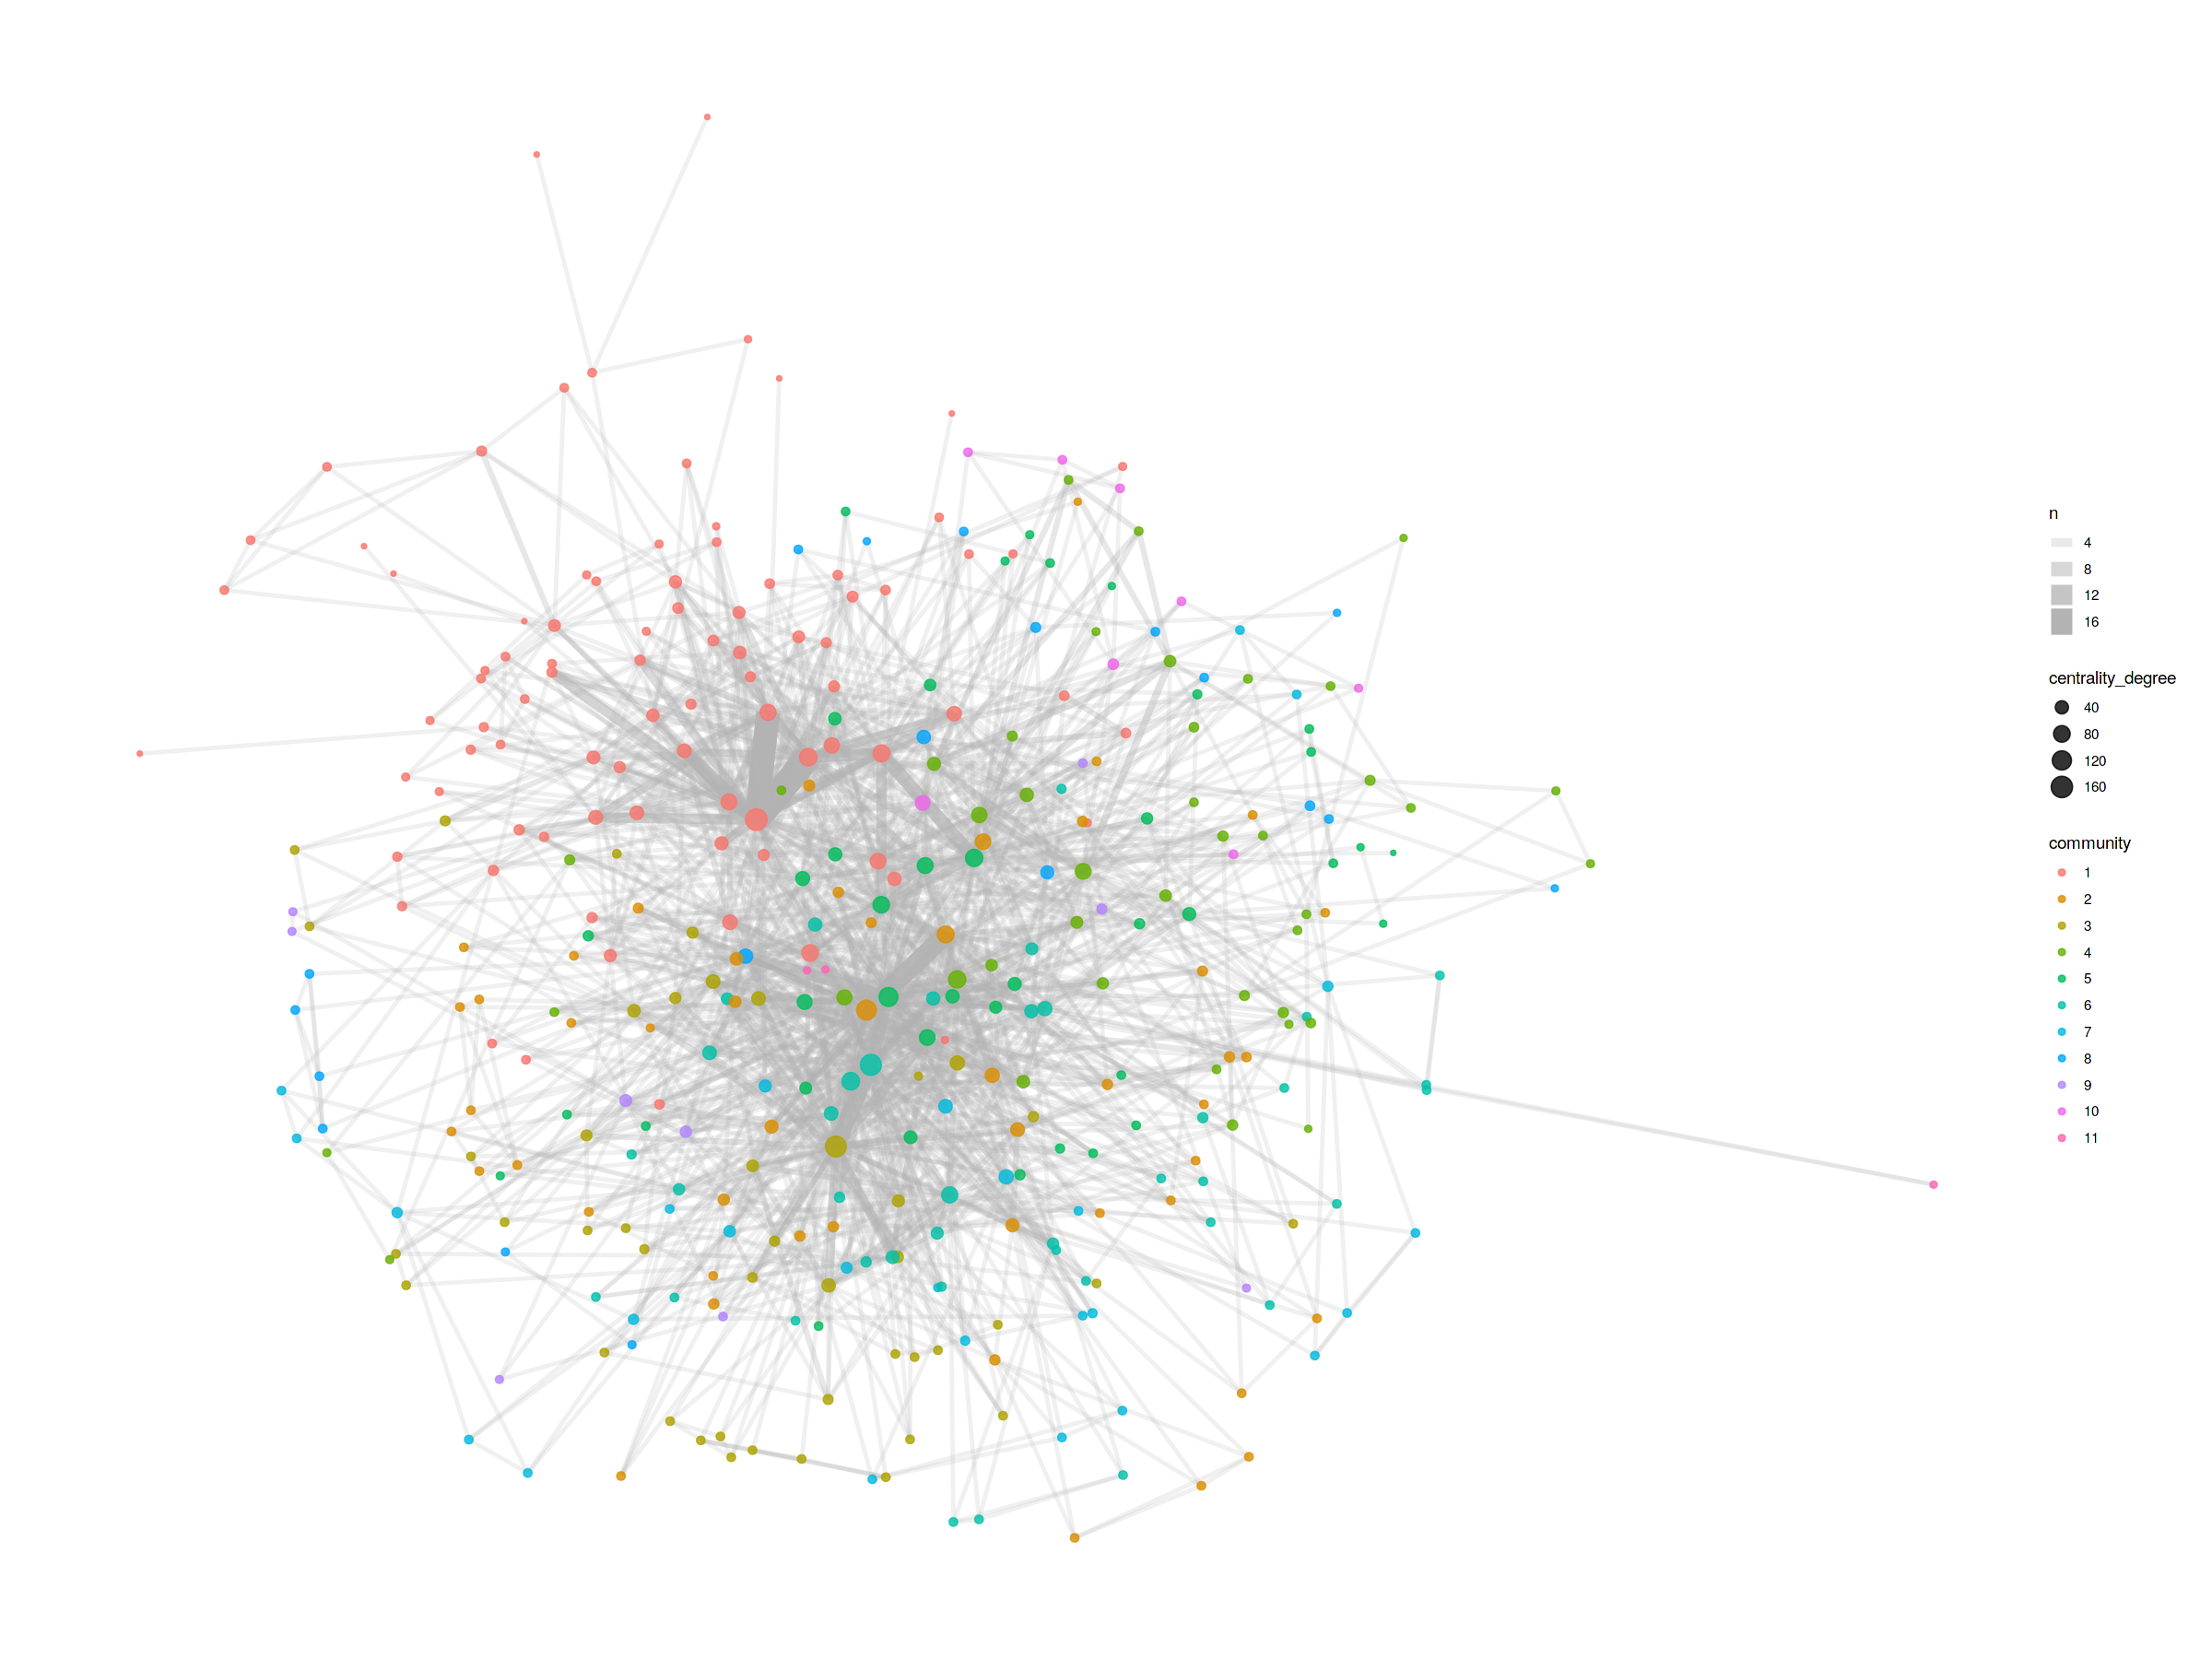

In [7]:
ggraph_df <- create_graph_df(n_ = 0)$ggraph_df
ggraph(ggraph_df,layout = 'kk') +
geom_edge_link(aes(width =n,alpha = n),color = 'gray70') + 
scale_edge_color_continuous(low = '#e56b6f',high = '#eaac8b')+
geom_node_point(aes(size = centrality_degree,color = community),alpha = 0.8) + 
theme_graph()

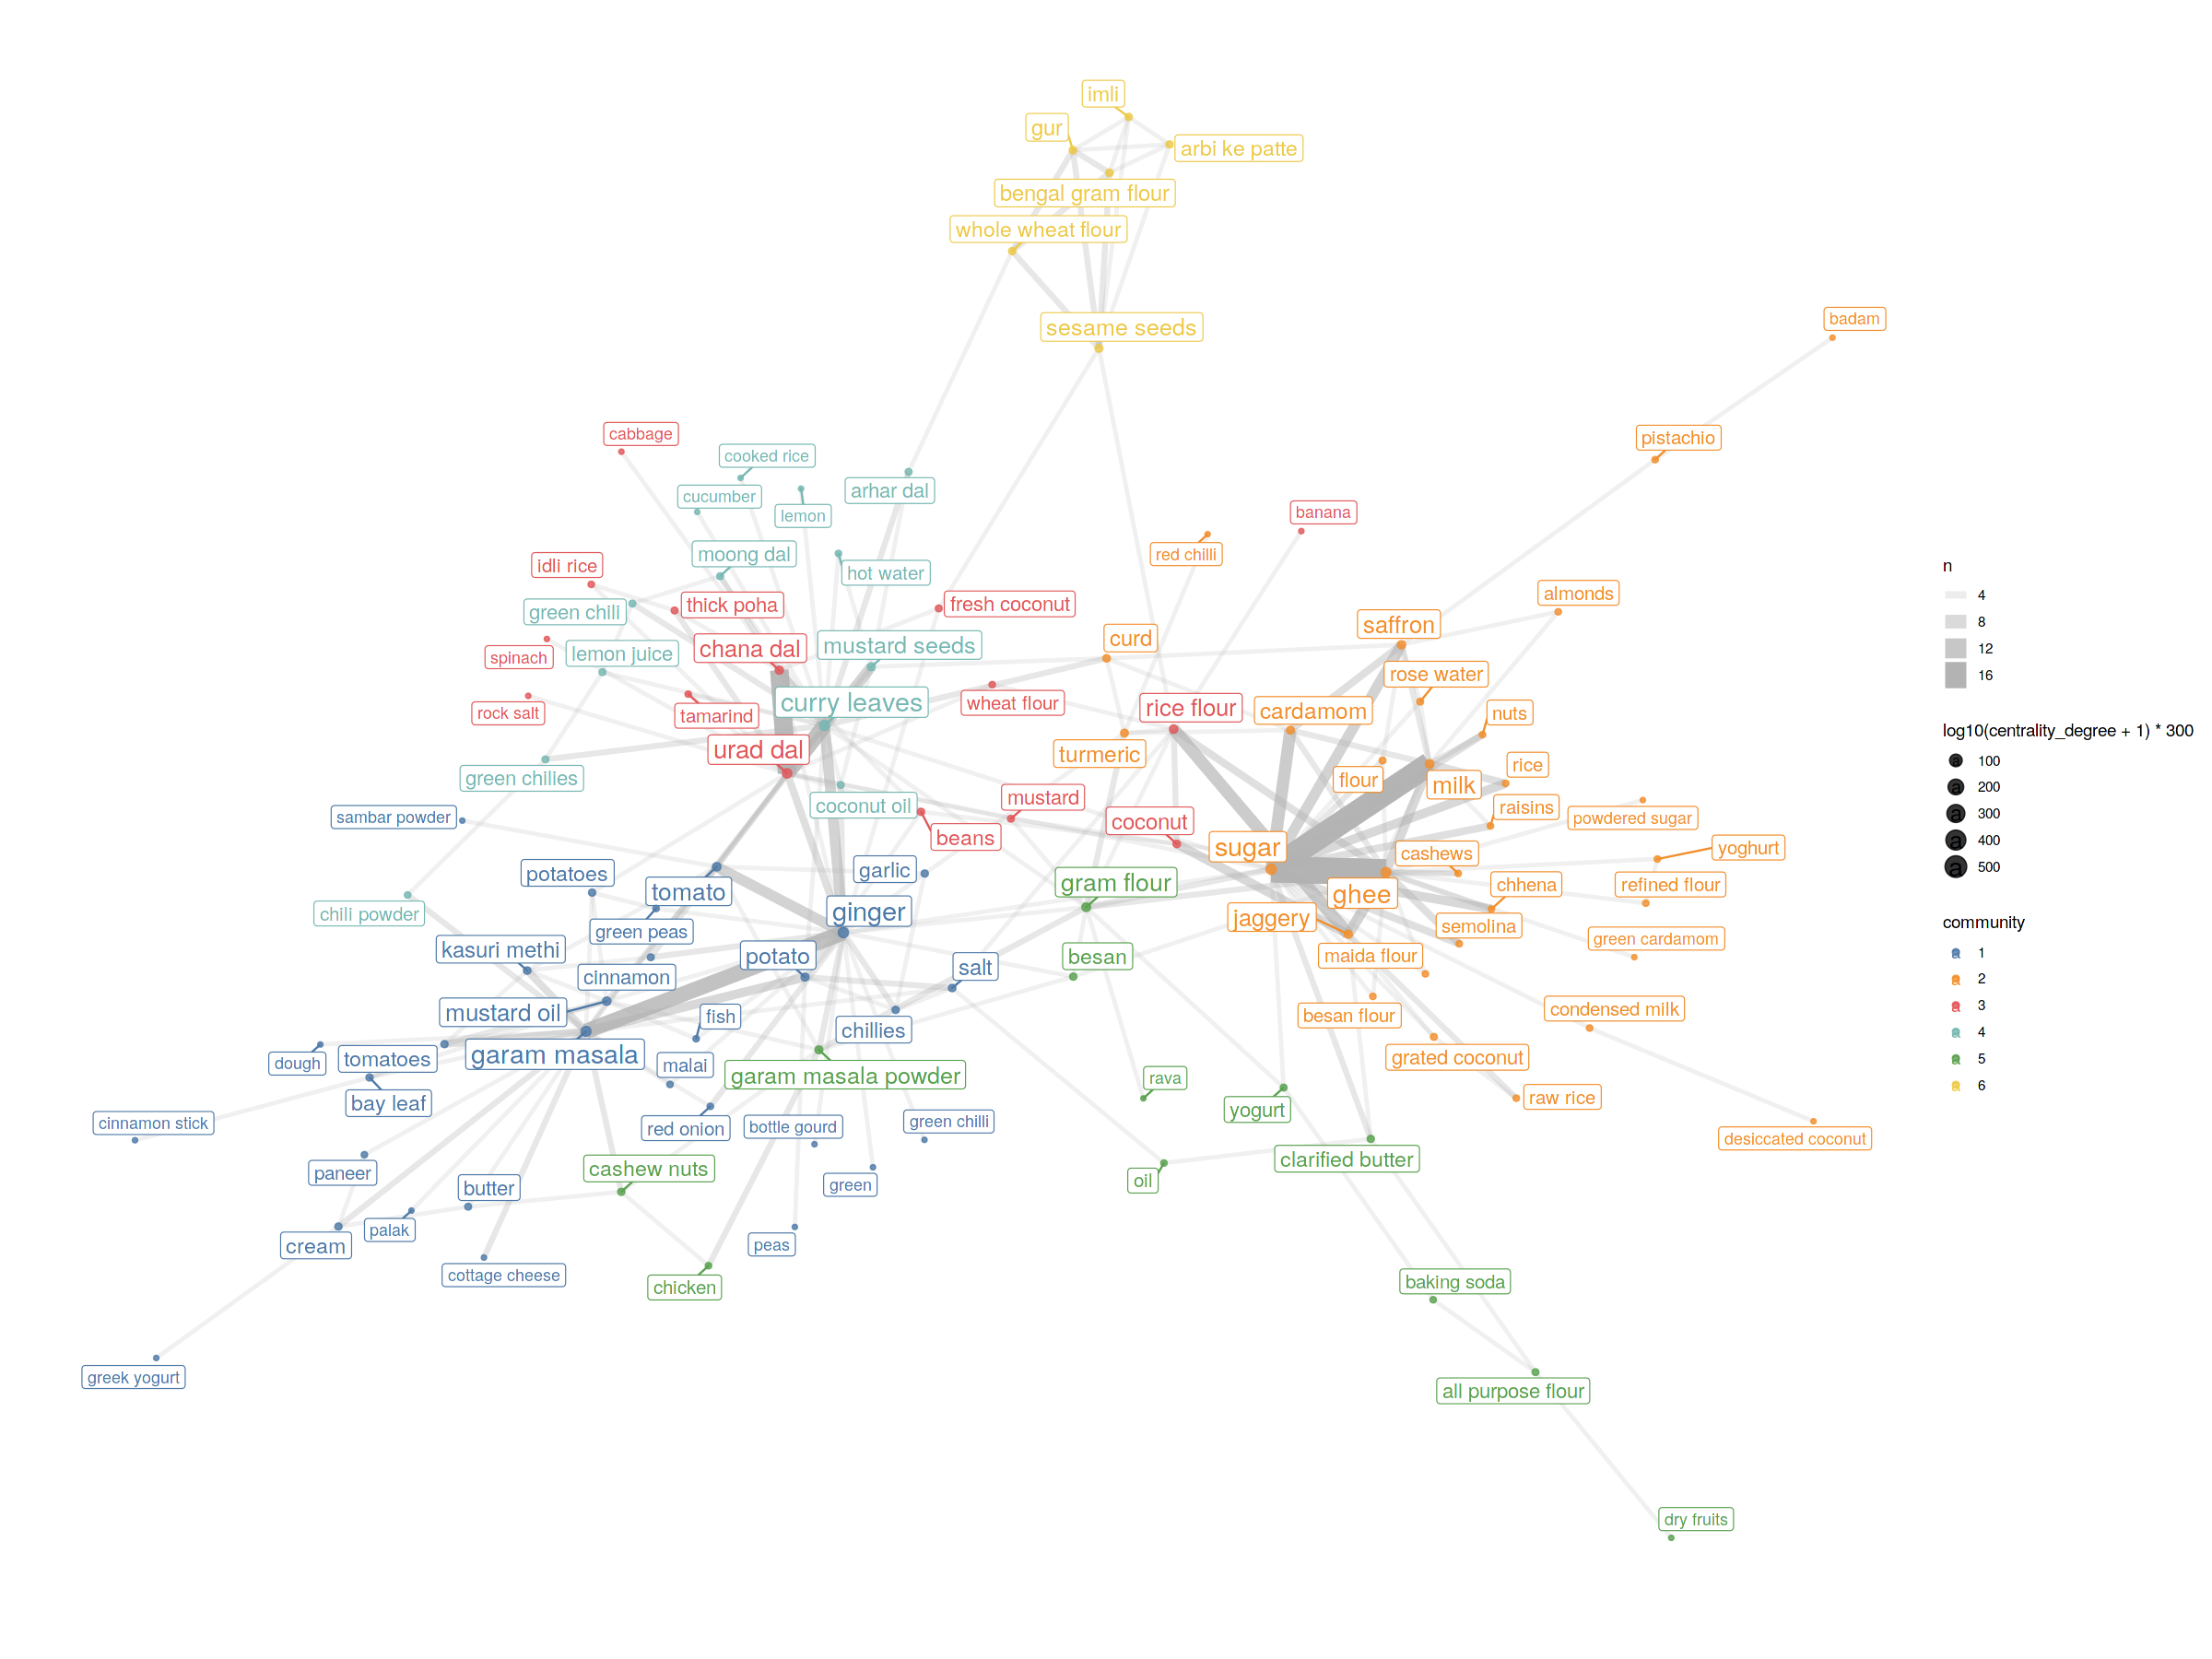

In [8]:
ggraph_df <- create_graph_df(n_ = 1)$ggraph_df
ggraph(ggraph_df,layout = 'nicely') +
geom_edge_link(aes(width =n,alpha = n),color = 'gray70') + 
scale_edge_color_continuous(low = '#e56b6f',high = '#eaac8b')+
geom_node_label(aes(label = name,color = community,size = log10(centrality_degree +1)*300),repel = TRUE)+
geom_node_point(aes(size = centrality_degree,color = community),alpha = 0.8) + 
scale_color_tableau()+
theme_graph()

Community detection:

Community detection in network analysis is closely related to clustering in machine learning. We are looking for nodes that belong to the same community cluster. There are many algorithms available for community detection. One of the most popular algorithms for extracting communities from networks is Louvian Algorithms, which I use in this Kernel. We can extract communities in the network to find different groups of ingredients that are used together.

Degree Centrality:

Degree centrality simply counts the number of links that are connected to a node. We can use this measure to identify ingredients that are used in many cuisines.

Betweenness Centrality:

Betweenness centrality computes how many times a node lies on the shortest path between that connects other nodes and tells us which nodes might act as a 'bridge' in the network. We can use this measure to understand which ingredients play an essential role in preparing different meals.

In [9]:
graph_edges_tbl <- create_graph_df(n = 0)$graph_edges_tbl
graph_nodes_tbl <- create_graph_df(n = 0)$graph_nodes_tbl
ggraph_df <- create_graph_df(n = 0)$ggraph_df
graph_nodes_tbl

name,centrality_degree,degree_between,community
<chr>,<dbl>,<dbl>,<fct>
all purpose flour,38,525.39526,4
almond,8,0.00000,2
almonds,30,311.65803,1
aloo,24,789.93076,7
alum powder,6,0.00000,1
amaranth leaves,8,0.00000,8
amchur powder,16,42.43995,5
apricots,2,0.00000,1
arbi ke patte,8,0.00000,4


# **1. Ingredients Variety**:

We will first study the variety of ingredients used in the Indian Dishes. Indian cuisine is widely regarded as being a delight to the taste buds. Coupled with this the fact that there are varied regions and cultures that make studying Indian Cuisine a deeply engrossing affair

In [10]:
p_ingredients_variety <- ingredients_new %>% count(ingredient_count, sort = TRUE) %>% 
  ggplot() + 
  geom_col(mapping = aes(x = n, y = reorder(ingredient_count, n), fill = as.factor(ingredient_count)), 
           show.legend = FALSE, 
           width = 0.75) + 
  geom_text(mapping = aes(x = n, y = reorder(ingredient_count, n), label = n), 
            show.legend = FALSE, 
            color = "white", 
            hjust = -0.25, 
            size = 3) + 
  scale_x_continuous(breaks = seq(0, 300, 25), labels = seq(0, 300, 25)) + 
  scale_fill_brewer(palette = "Set1") + 
  theme_solarized(light = FALSE, base_size = 10) + 
  theme(axis.title = element_text(colour = "white"), 
        axis.text = element_text(colour = "white"), 
        axis.ticks = element_line(colour = "white"), 
        plot.title = element_text(colour = "white", size = rel(1.25), face = "bold"), 
        plot.subtitle = element_text(colour = "white", size = rel(1.15))) + 
  labs(x = "No of Dishes", 
       y = "No of Ingredients", 
       title = "Indian Food", 
       subtitle = "Variety of Ingredients")


ggsave(filename = "p_ingredients_variety.png", plot = p_ingredients_variety)


Saving 12.5 x 6.67 in image



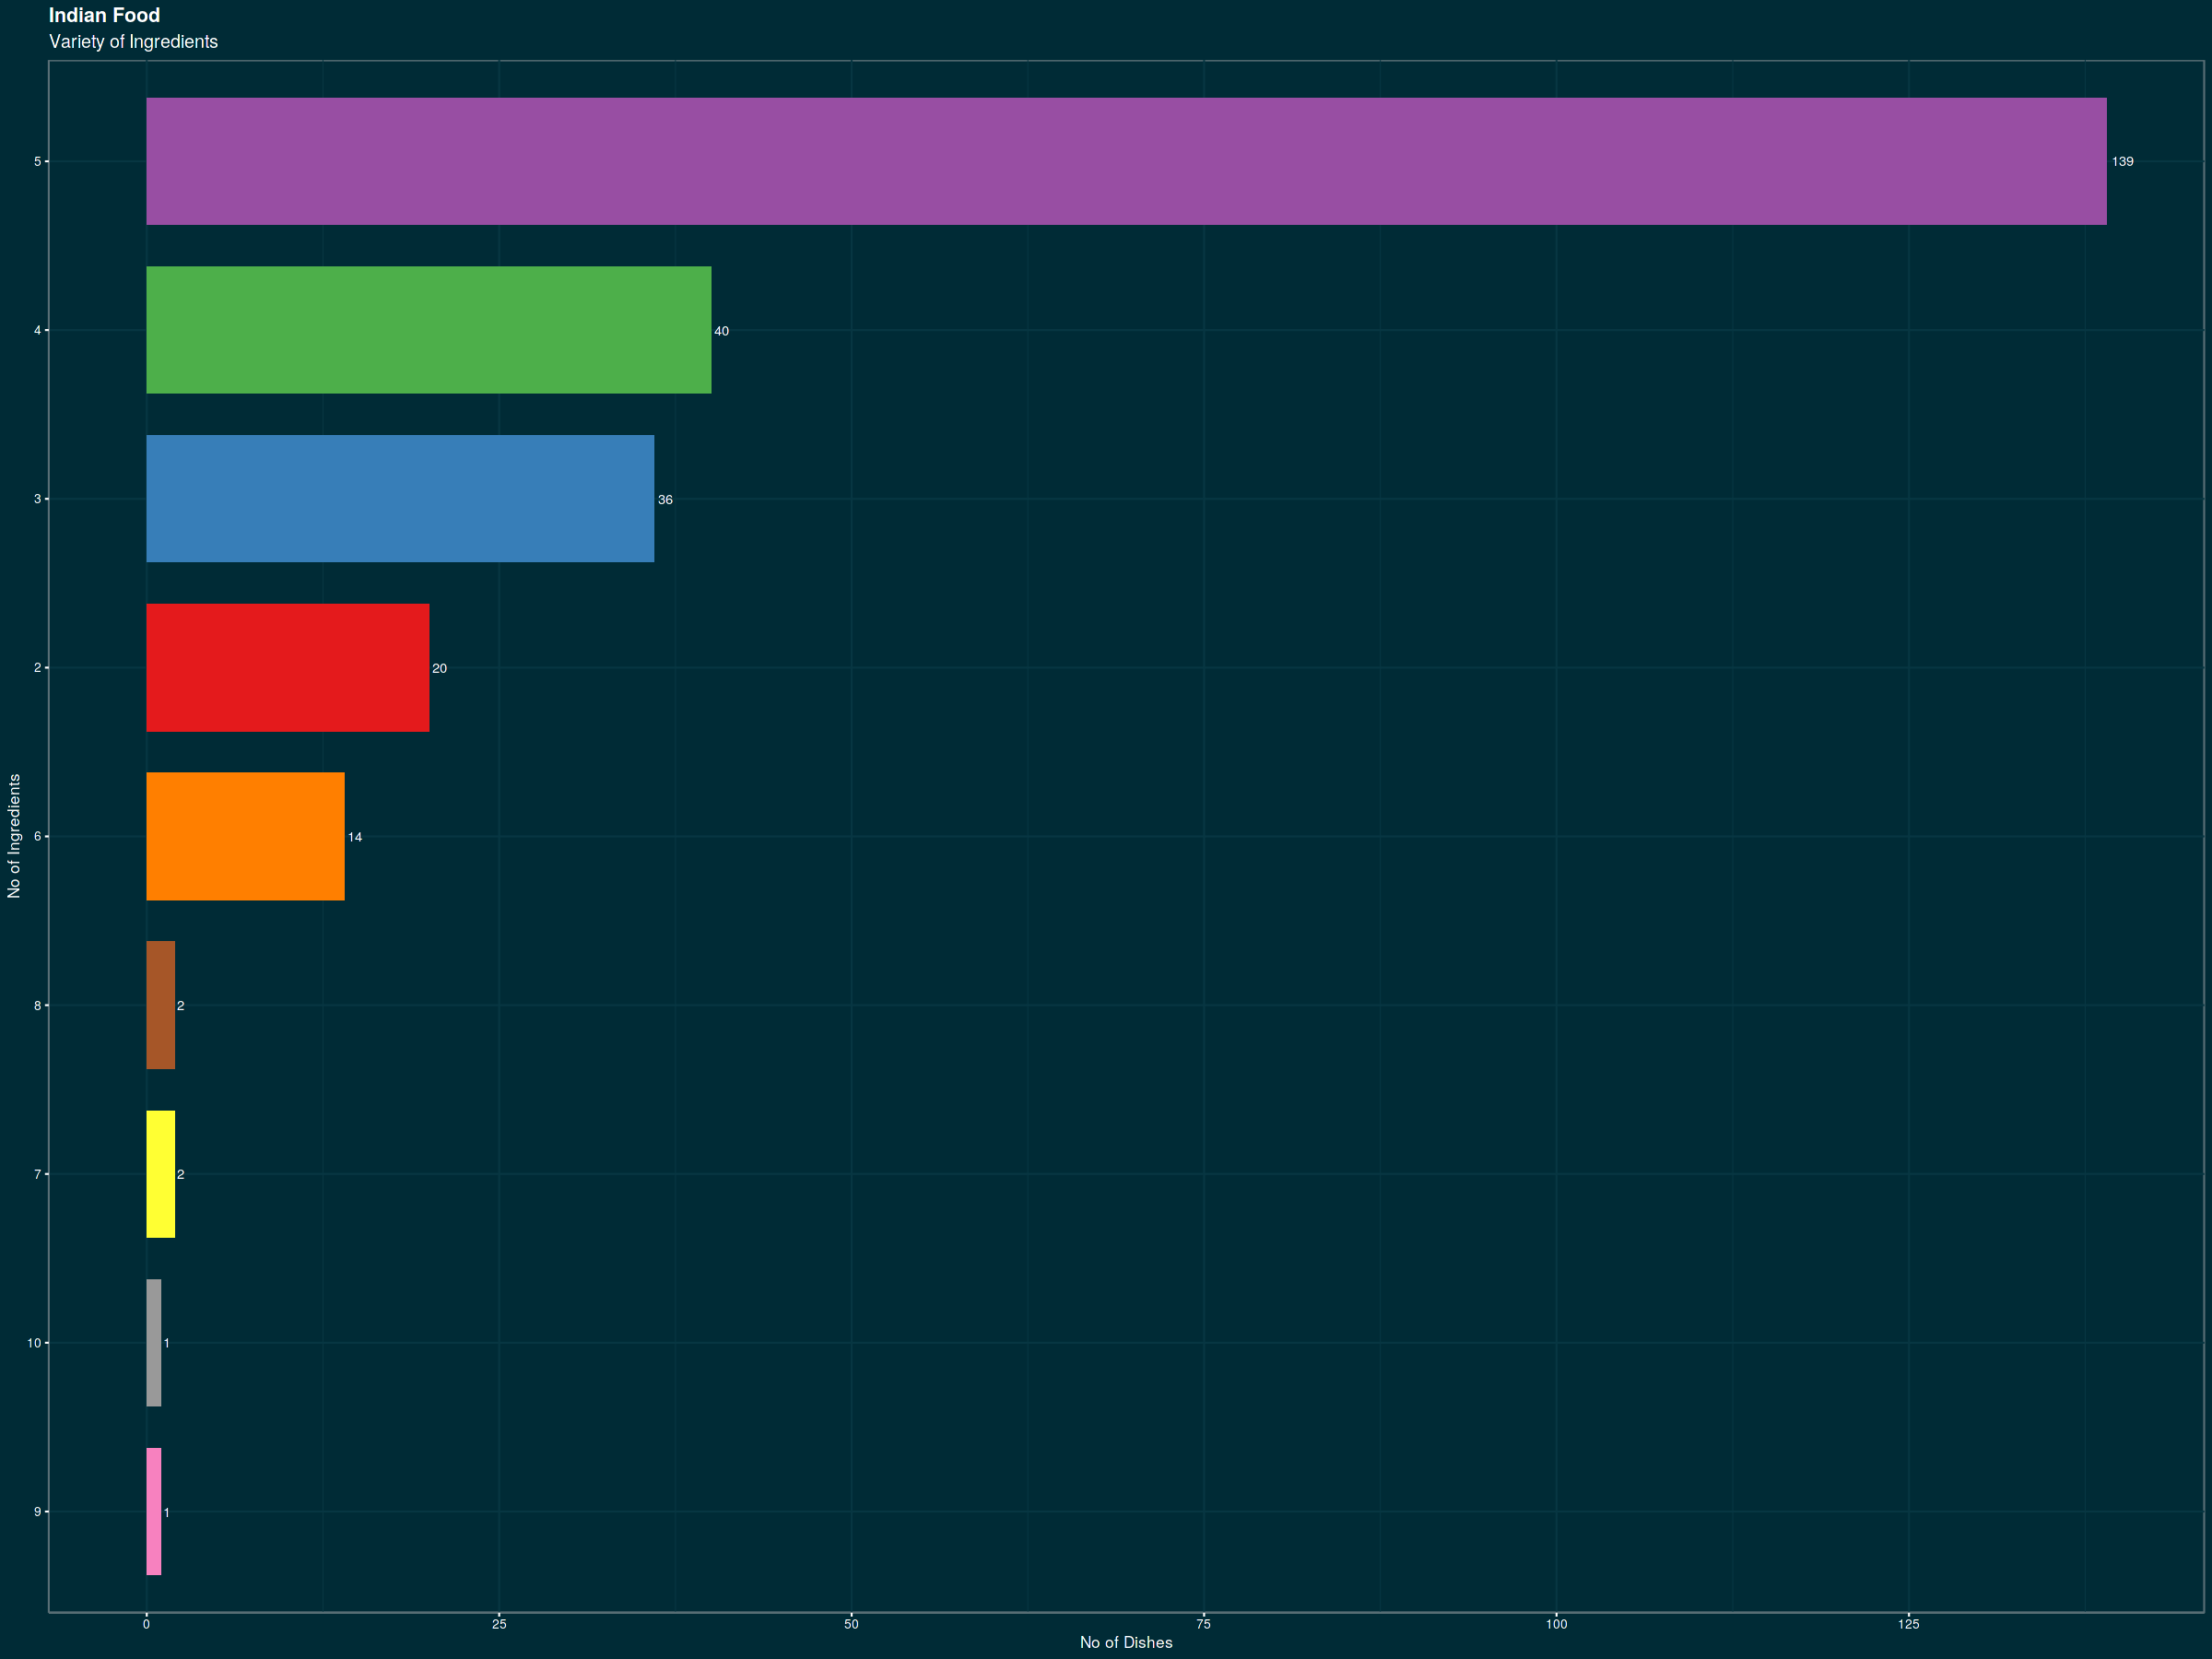

In [11]:
p_ingredients_variety

As can be seen from the above figure we have 139 dishes having 5 ingredients. The above distribution also speaks about the variety of ingredients used in Indian Dishes. 40 dishes have 4 ingredients and 36 dishes have 3 inrgedients. Even more interesting fact is we have dishes that use more than 7 to 8 ingredients in them.

# 2. Top Ingredients in Indian Dishes
We will now concentrate on the popular ingredients used in India Dishes faceted by Vegetarian/Non-Vegetarian foods.

In [12]:
fn_get_pivot_ingredients <- function(x){
  
  df_xx <- data.frame()
  v1 <- vector(mode = "integer", length = 1)
  v2 <- vector(mode = "integer", length = 1)
  
  for (i in seq(length(x[[1]]))){
    
    v1 <- x[[1]][i]
    v2 <- x[[2]][i]
    v3_len <- length(x[[3]][[i]])
    
    rown <- rep(v1, v3_len)
    name <- rep(v2, v3_len)
    ingr <- x[[3]][[i]]    
    
    df_xx <- bind_rows(df_xx, bind_cols("rown" = rown, 
                                        "name" = name, 
                                        "ingr" = ingr))
    
    
  }
  
 return(df_xx)
}


df_final <- fn_get_pivot_ingredients(as.list(ingredients_new[1:nrow(ingredients_new), c(1, 2, 4)]))


ingredients_pivoted <- as_tibble(df_final)


indian_food_details <- inner_join(indian_food, 
                                  ingredients_pivoted, 
                                  by = "name") 

p_top_ingredients <- indian_food_details %>% group_by(diet, ingr) %>% 
  summarise(cnt = n()) %>% 
  ungroup() %>% 
  group_by(diet) %>% 
  top_n(n = 5, wt = cnt) %>%
  ungroup() %>% 
  ggplot() + 
  geom_col(mapping = aes(x = cnt, y = reorder_within(ingr, cnt, diet), fill = ingr), show.legend = FALSE, width = 0.5) + 
  geom_text(mapping = aes(x = cnt, y = reorder_within(ingr, cnt, diet), label = cnt), show.legend = FALSE, hjust = -0.4, color = "white", size = 3, fontface = "bold") + 
  facet_wrap(facets = ~diet, scales = "free") + 
  scale_y_reordered() + 
  scale_fill_brewer(palette = "Paired") + 
  theme_solarized_2(light = FALSE, base_size = 12) + 
  theme(axis.title = element_text(colour = "white"), 
        axis.text =  element_text(colour = "white"), 
        strip.text = element_text(colour = "white", size = 12), 
        plot.title = element_text(colour = "goldenrod1", size = rel(1.25), face = "bold"), 
        plot.subtitle = element_text(colour = "goldenrod1", size = rel(1.15))
        ) + 
  labs(x = "No of Dishes", 
       y = "", 
       title = "Indian Food - Top Ingredients", 
       subtitle = "Popular Ingredients by Diet Type")

ggsave(filename = "p_top_ingredients.png", plot = p_top_ingredients)




`summarise()` regrouping output by 'diet' (override with `.groups` argument)

Saving 12.5 x 6.67 in image



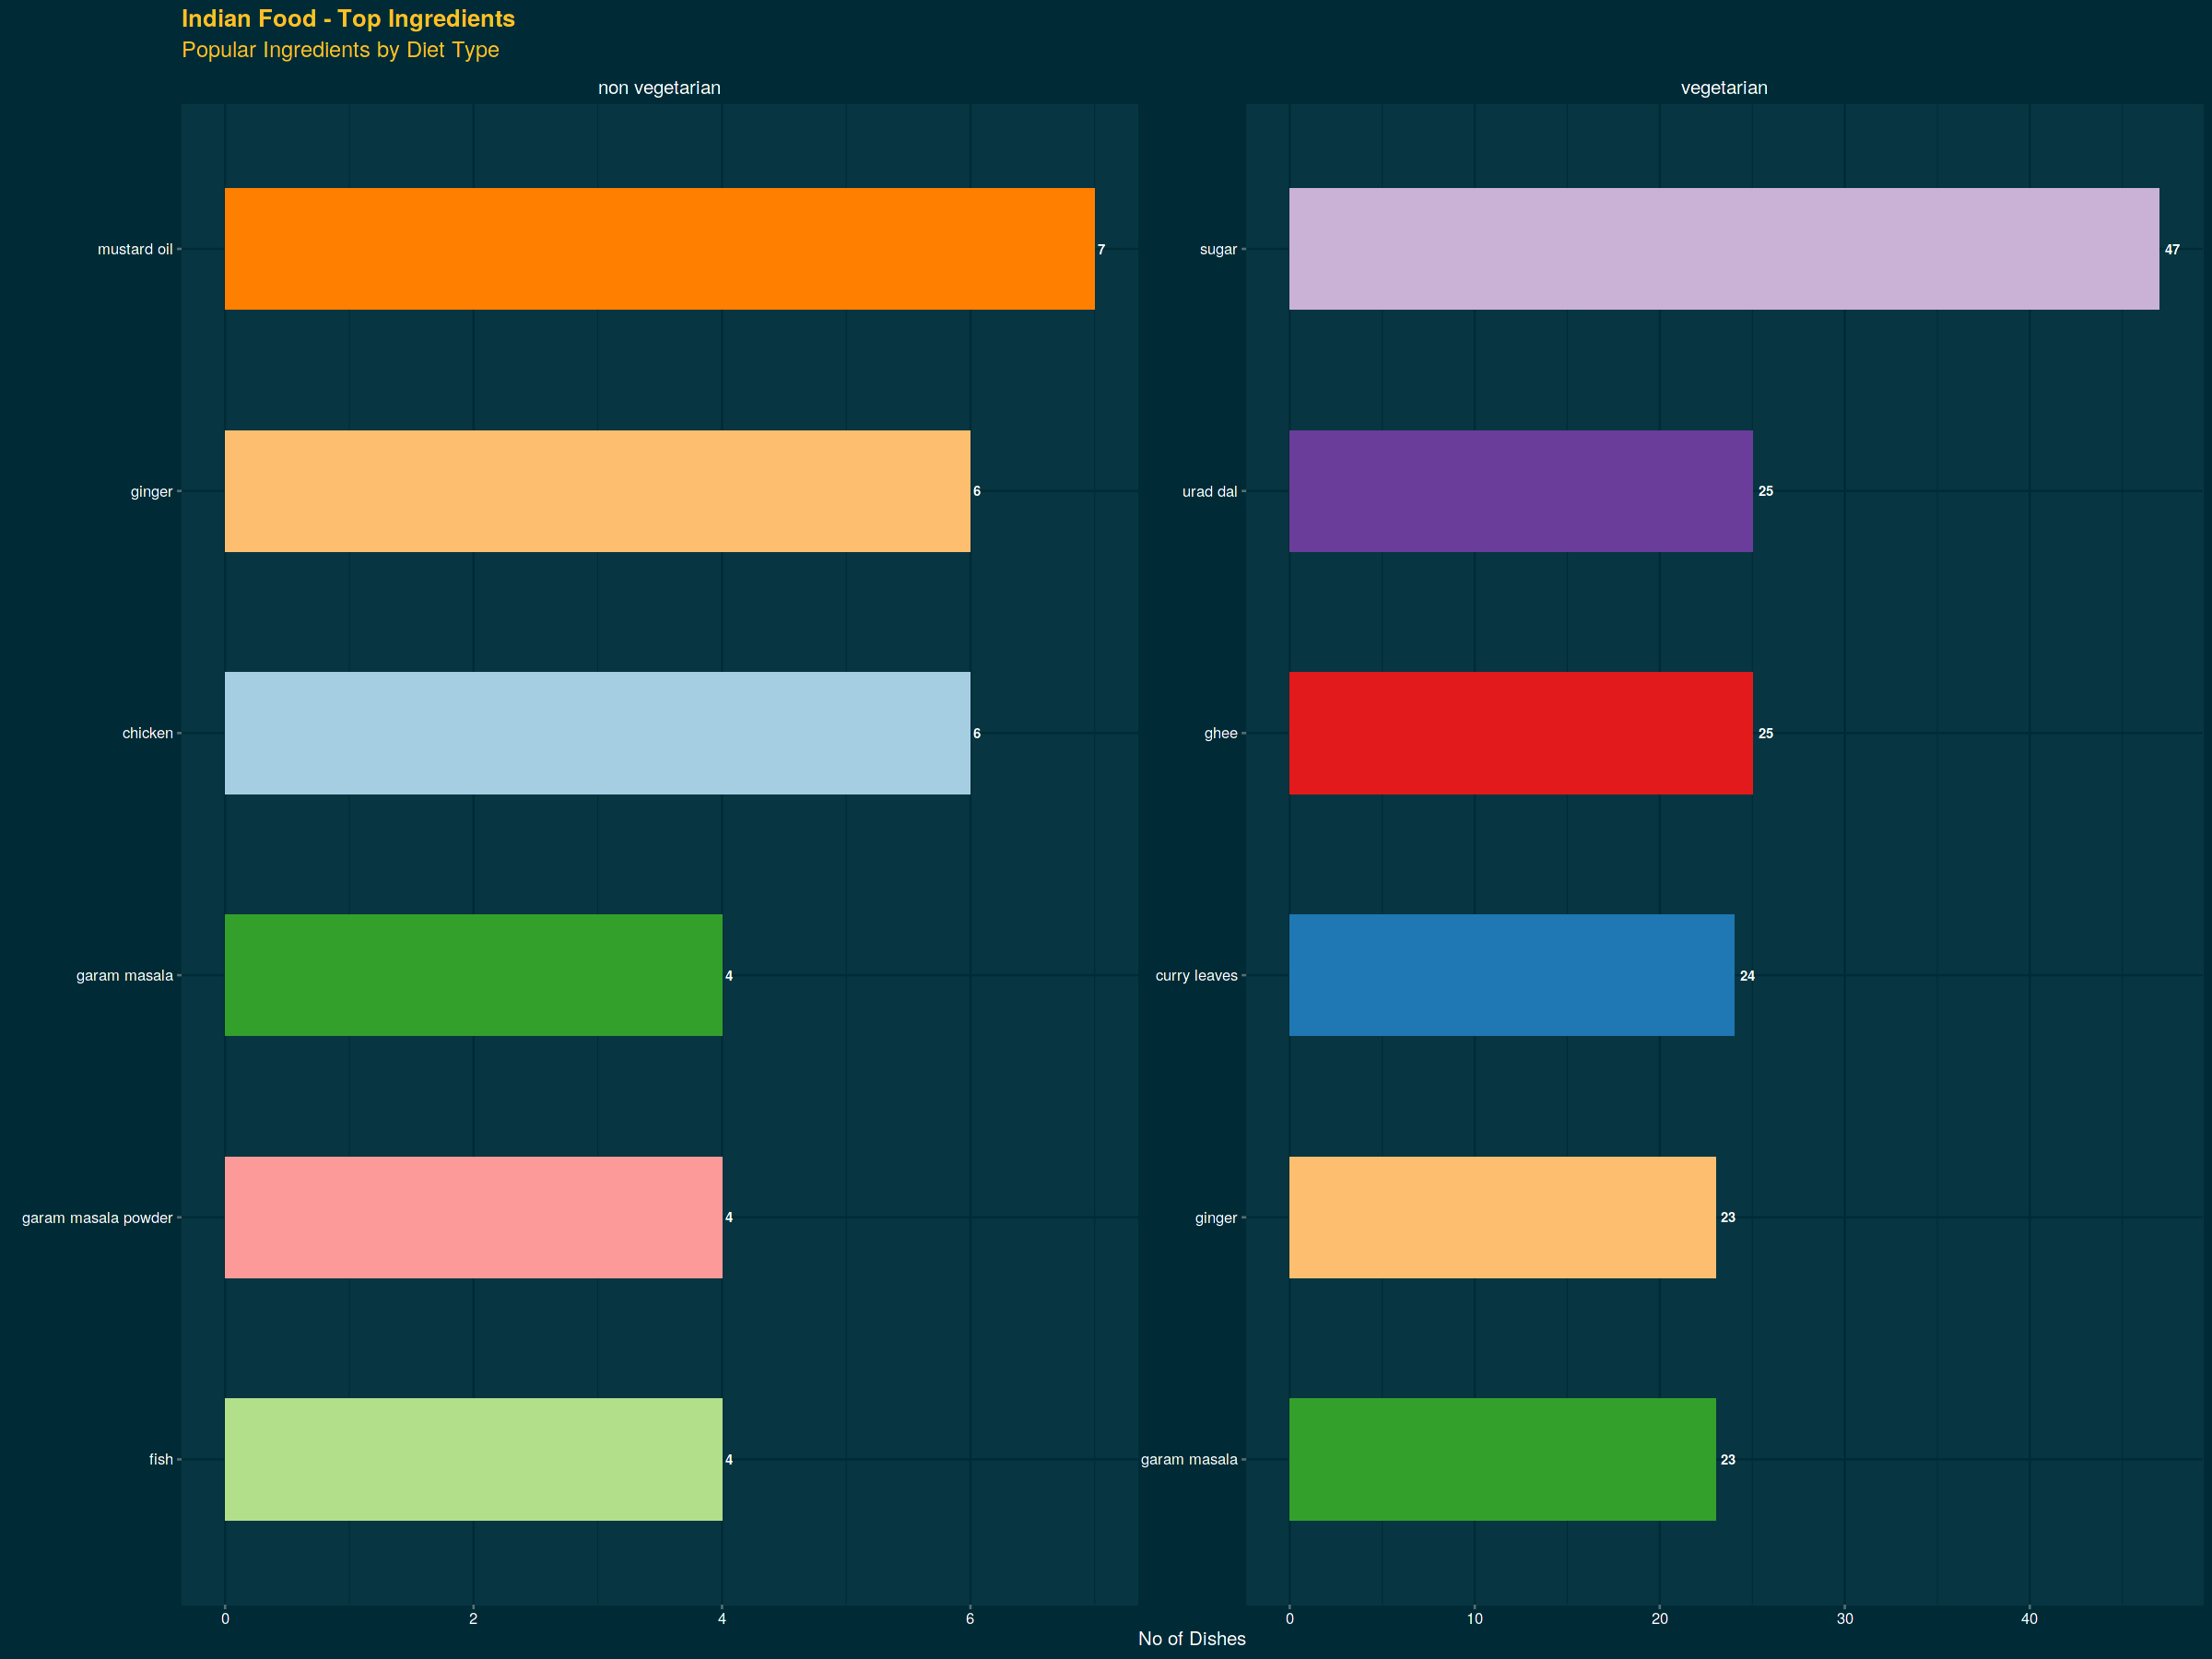

In [13]:
p_top_ingredients

The above plot shows the below facts

Non-Vegetarian Foods - Mustard Oil, Ginger and Chicken are the top ingredients for Non-vegetarian dishes. Generous use of oil has always been a defining measure to enhance the taste and mustard oil is known for this. Chicken is as always the most popular ingredient in any non-vegetarian food
Vegetarian Foods - Just as Mustard Oil Sugar also makes food tastier and hence it lies at the top of the popular ingredients. Urad Dal and Ghee are the also the top ingredients used in Vegetarian Dishes.



# 3. Similar Dishes
In this third section of the notebook we will try and find out cuisines that have the same ingredients and also the distribution of the similarity in ingredients across the entire set of the Indian Dishes. This part of the analysis has been the most intenstive in as much as this involved comparing of all possible distinct combination of all the 255 Dishes in the dataset.




In [14]:
# Get all combination of rows 
df_temp_1 <- expand.grid(ingredients_new$rown, 
                         ingredients_new$rown)

# Set the column names of the dataframe
colnames(df_temp_1) <- c("rown_1", "rown_2")


# Select unique combinations (not permutations)

df_temp_2 <- as_tibble(df_temp_1[df_temp_1$rown_2 > df_temp_1$rown_1, ])



# Join with ingredients_new to get the name and ingredient list of _1

df_temp_3 <- inner_join(df_temp_2, 
                        ingredients_new %>% select(rown_1 = rown, 
                                                   name_1 = name, 
                                                   ingredients_list_1 = ingredients_list), 
                        by = "rown_1"
)


# Join with ingredients_new to get the name and ingredient list of _2

df_temp_4 <- inner_join(df_temp_3, 
                        ingredients_new %>% select(rown_2 = rown, 
                                                   name_2 = name, 
                                                   ingredients_list_2 = ingredients_list), 
                        by = "rown_2"
)

# Function to get the similarities of ingredients 
# between the _1 dish and the _2 dish 

get_similar_counts <- function(matrix_1){
  
  return(sum(matrix_1[[1]] %in% matrix_1[[2]]))
}



# Use apply function with all data and get the simlarity against each combination
# of dishes 

out_result <- apply(X = as.matrix(df_temp_4[, c("ingredients_list_1", "ingredients_list_2")]), MARGIN = 1, FUN = get_similar_counts)

# convert the matrix result to a dataframe 
final_out_result <- as.data.frame(out_result)


# set the column names of the resulting data frame 
colnames(final_out_result) <- "similarity_no"


# add final_out_result as a column and create the final data frame 

ingredients_final <- bind_cols(df_temp_4, final_out_result) %>% 
  select(rown = rown_1, name_1, name_2, similarity_no)





The below are dishes which are similar in term of the ingredients. The last column of the table below shows that the ingredients match 100% between the two dishes compared.

In [15]:
# What are the similar dishes ?? ------------------------

similar_foods <- inner_join(ingredients_final, 
           ingredients_new %>% 
             select(rown, ingredient_count), by = "rown") %>% 
  mutate(prop_similar = round(similarity_no / ingredient_count, digits = 2) * 100) %>% 
  filter(prop_similar == 100) %>% 
  select(dish_1 = name_1, dish_2 = name_2, ingredient_count, prop_similar)


similar_foods

dish_1,dish_2,ingredient_count,prop_similar
<chr>,<chr>,<int>,<dbl>
Boondi,Laddu,3,100
Boondi,Sohan papdi,3,100
Laddu,Sohan papdi,3,100
Chhena jalebi,Ledikeni,3,100
Chhena jalebi,Pantua,3,100
Ledikeni,Pantua,3,100
Mihidana,Mysore pak,3,100
Kajjikaya,Modak,3,100
Mahim halwa,Shankarpali,2,100


We can see that most of the similar dishes are sweets from different parts of the country. Mihidana and Mysore Pak is an example. Mihidana is a sweet dish from the Eastern part of the country where as Mysore Pak is from the Southern part of the country but both have 100% similarity in the ingredients used. Boondi, Sohan papdi and Laddu are similar in composition but probably in the ratio of the ingredients used the tastes vary. Misti Doi is a sweet delicacy in Eastern India. The same dish is also called Paravannam in Southern parts of the country meaning "Heavenly Food". Misti Doi is a treat to the taste buds as anyone from Kolkata and Eastern part of the Country would agree.




The next graphic will show the distribution of ingredient similarity in the Indian Dishes.

In [16]:
p_ingredients_similarity <- ingredients_final %>% count(similarity_no, sort = TRUE) %>% 
  transmute(combinations = n, similarities = similarity_no) %>% 
  ggplot() + 
  geom_col(mapping = aes(x = combinations, y = reorder(as.factor(similarities), combinations), fill = as.factor(similarities)), show.legend = FALSE, width = 0.5) +
  geom_text(mapping = aes(x = combinations, y = reorder(as.factor(similarities), combinations), label = combinations), nudge_x = 1000, size = 3, color = "white", fontface = "bold") + 
  scale_fill_brewer(palette = "Set2") + 
  scale_x_continuous(breaks = seq(0, 30000, 5000), 
                     labels = seq(0, 30000, 5000), 
                     limits = c(0, 29000)) + 
  theme_solarized_2(light = FALSE, base_size = 12) + 
  theme(
    axis.text.x = element_text(colour = "white"), 
    axis.title = element_text(colour = "white"), 
    axis.text.y = element_text(colour = "white"), 
    plot.title = element_text(colour = "goldenrod1", face = "bold"), 
    plot.subtitle = element_text(colour = "goldenrod1")
  ) + 
  labs(x = "Food Combinations", 
       y = "No of Similar Ingredients", 
       title = "Indian Foods", 
       subtitle = "Ingredient Similarity Analysis")


In [17]:
ggsave(filename = "p_ingredients_similarity.png", plot = p_ingredients_similarity)

Saving 12.5 x 6.67 in image



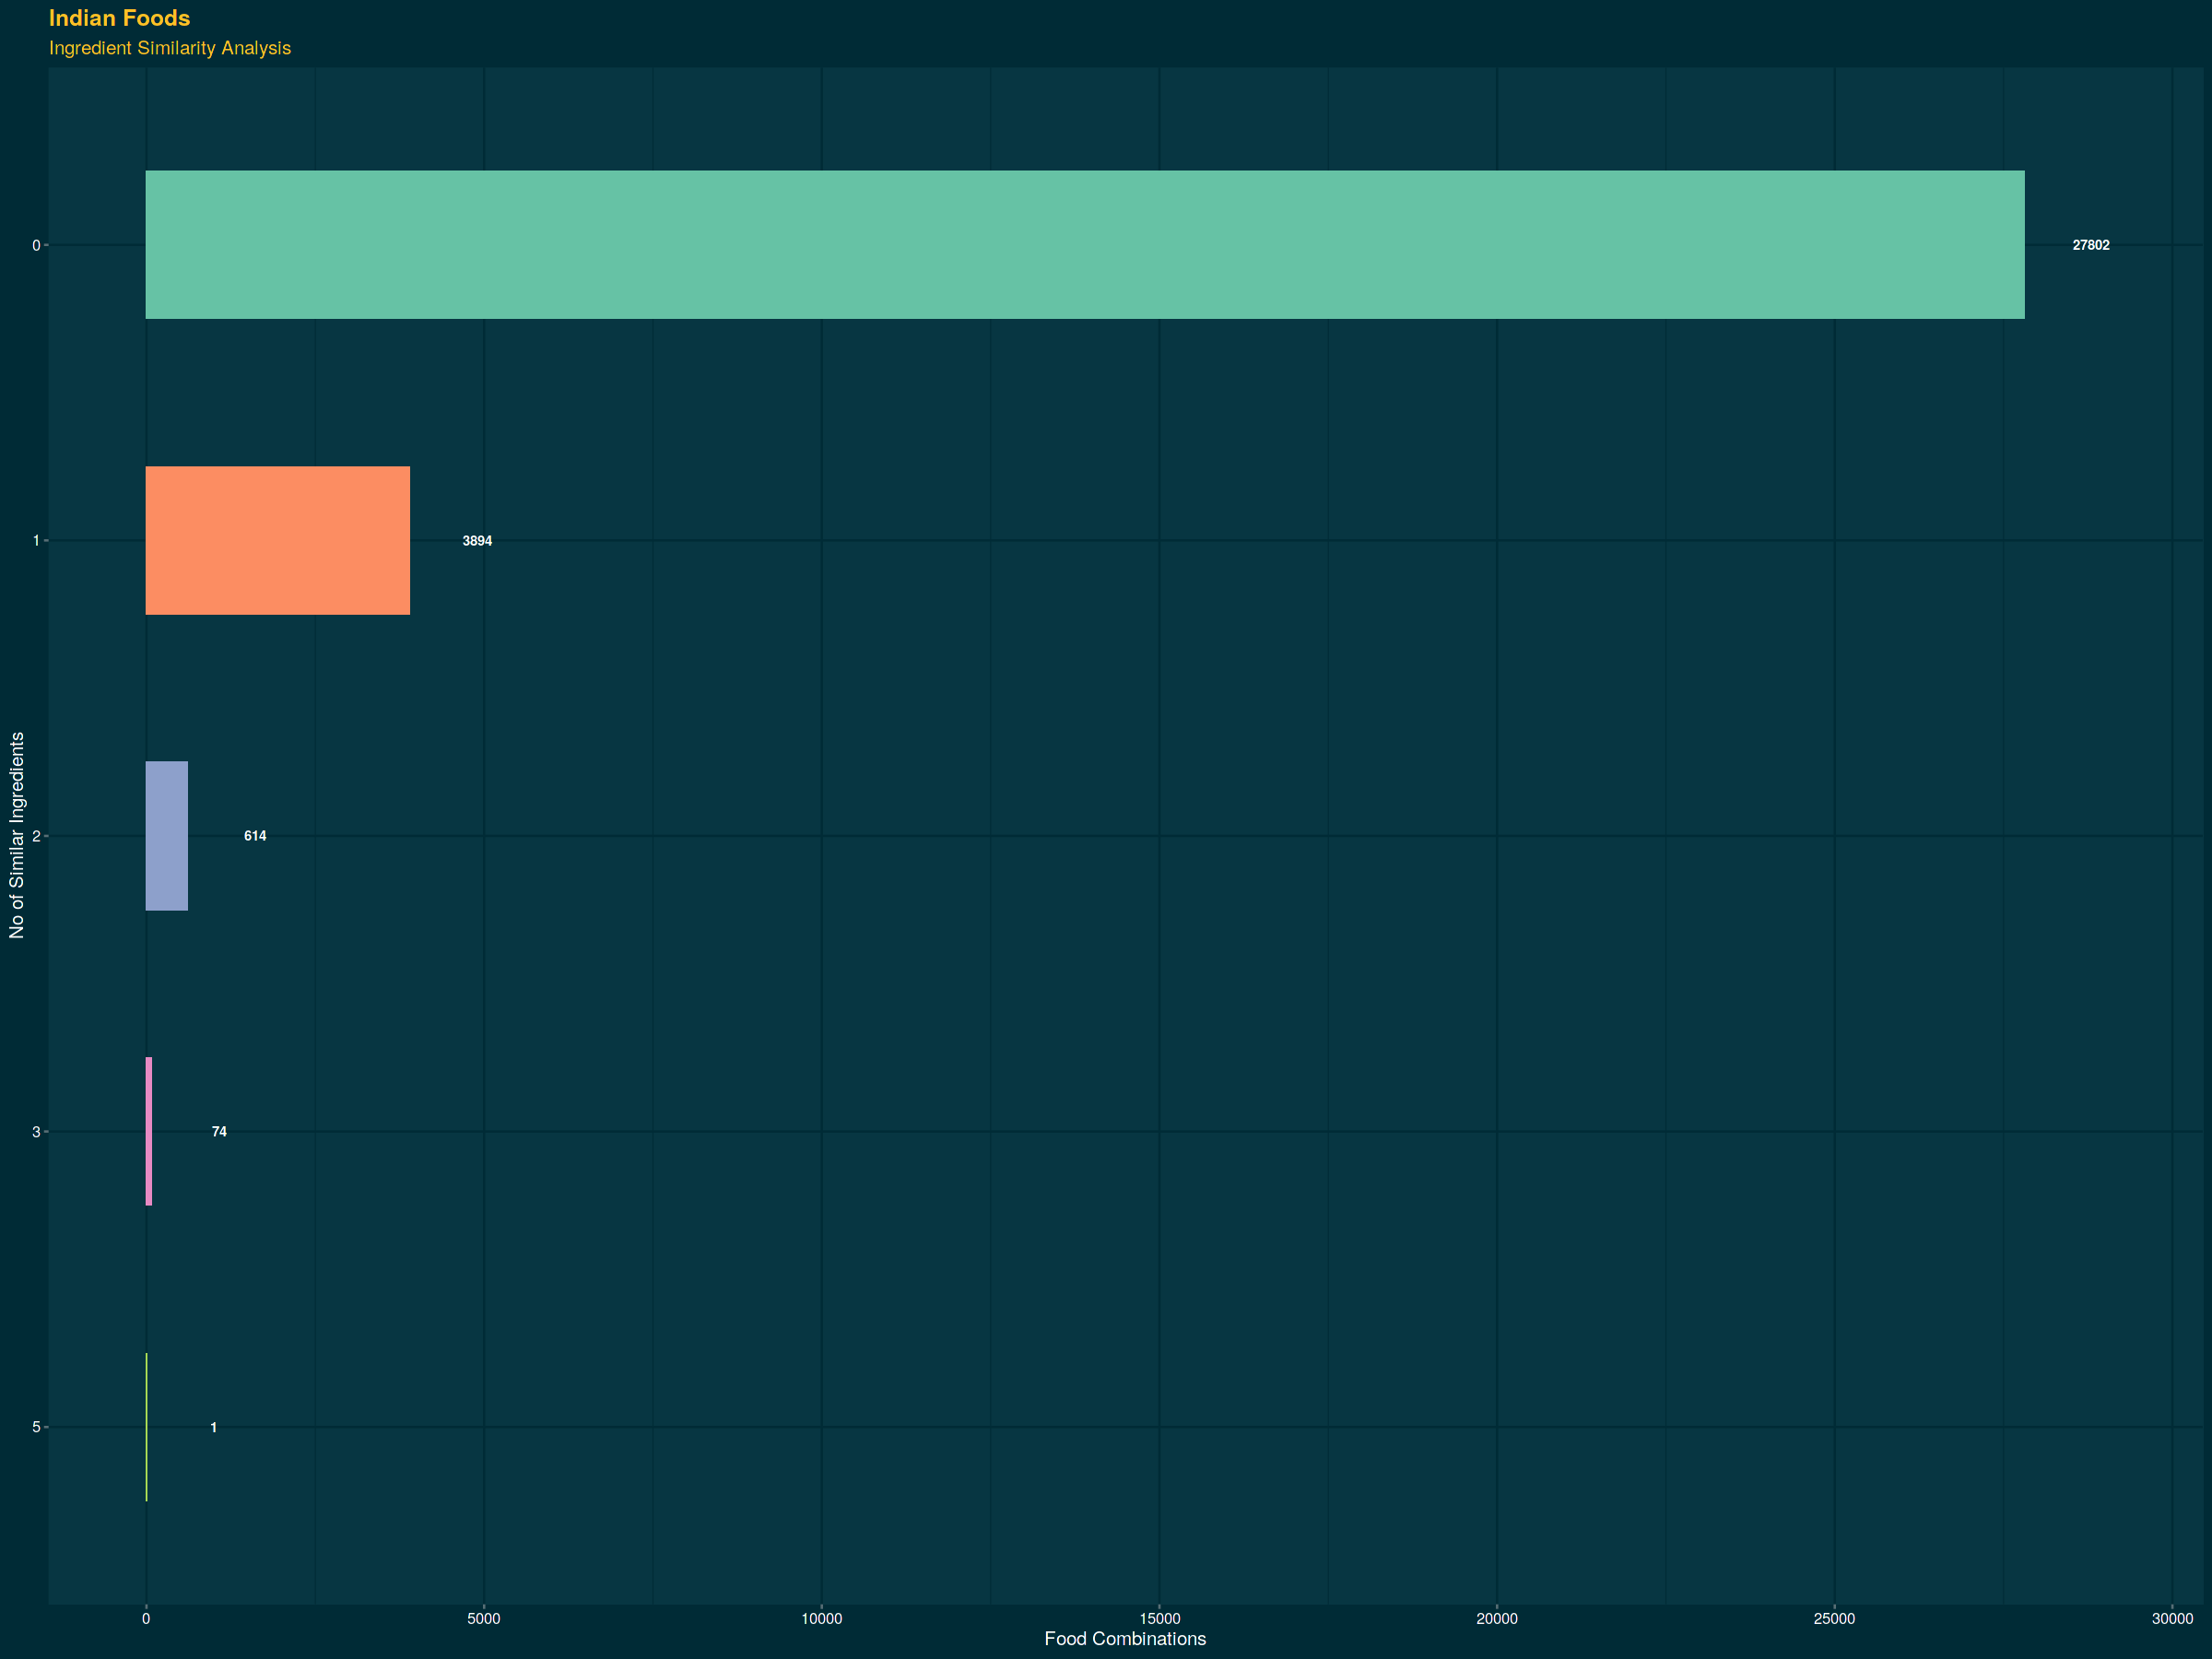

In [18]:
p_ingredients_similarity

27802 combination of Indian Dishes have no similarity. Of course a sweet dish will not have similar ingredients as a spicy dish but the above figure goes to show the variety of the Indian Cuisine in as much as how the ingredients can be juggled and combined to give rise to a large number of dishes. 74 Dishes have 3 ingredients common in between them. Out of these dishes as we discussed above some of the dishes have 100% similarity in ingredients.

# 4. Longest and Quickest Cooking Dishes

We now study the longest and quickest cooking dishes in terms of time. Energetic and enthusiastic persons who can spend good amount of time in the kitchen may not be interested but lazy un-enthusiastic persons may always be searching for food that cooks quickly and also good in taste. Hopefully the graphics below will throw some light into these facts.

In [19]:
p_longest_dishes <- indian_food_details %>% distinct(name, prep_time, cook_time, course) %>% 
  mutate(total_cook_time = prep_time + cook_time) %>% 
  group_by(course) %>% 
  top_n(n = 5, wt = total_cook_time) %>% 
  ungroup() %>% 
  arrange(course, desc(total_cook_time)) %>% 
  ggplot() + 
  geom_col(mapping = aes(x = total_cook_time, y = reorder_within(name, total_cook_time, course)), 
           show.legend = FALSE, 
           fill = "darkolivegreen2", 
           width = 0.5) + 
  geom_text(mapping = aes(x = total_cook_time, y = reorder_within(name, total_cook_time, course), label = total_cook_time), show.legend = FALSE, hjust = -0.4, color = "white", size = 2) + 
  scale_y_reordered() + 
  facet_wrap(facets = ~course, scales = "free") + 
  theme_solarized_2(light = FALSE, base_size = 12) + 
  theme(
    axis.text.x = element_text(colour = "white"), 
    axis.title = element_text(colour = "white"), 
    axis.text.y = element_text(colour = "white"), 
    plot.title = element_text(colour = "white", face = "bold"), 
    plot.subtitle = element_text(colour = "white"), 
    strip.text = element_text(colour = "white")
  ) + 
  labs(x = "Prep Time + Cook Time", 
       y = "", title = "Longest Cooking Dishes", 
       subtitle = "Dishes by Course")


p_quickest_dishes <- indian_food_details %>% distinct(name, prep_time, cook_time, course) %>% 
  mutate(total_cook_time = prep_time + cook_time) %>% 
  filter(total_cook_time != 0) %>% 
  group_by(course) %>% 
  top_n(n = 3, wt = -total_cook_time) %>% 
  ungroup() %>% 
  arrange(course, desc(total_cook_time)) %>% 
  ggplot() + 
  geom_col(mapping = aes(x = total_cook_time, y = reorder_within(name, total_cook_time, course)), show.legend = FALSE, fill = "goldenrod1", width = 0.5) + 
  geom_text(mapping = aes(x = total_cook_time, y = reorder_within(name, total_cook_time, course), label = total_cook_time), show.legend = FALSE, hjust = -0.4, color = "white", size = 2) + 
  scale_y_reordered() + 
  facet_wrap(facets = ~course, scales = "free") + 
  theme_solarized_2(light = FALSE, base_size = 10) + 
  theme(
    axis.text.x = element_text(colour = "white"), 
    axis.title = element_text(colour = "white"), 
    axis.text.y = element_text(colour = "white"), 
    plot.title = element_text(colour = "white", face = "bold"), 
    plot.subtitle = element_text(colour = "white"), 
    strip.text = element_text(colour = "white")
  ) + 
  labs(x = "Prep Time + Cook Time", 
       y = "", title = "Quickest Cooking Dishes", 
       subtitle = "Dishes by Course")

  

In [20]:
ggsave(filename = "p_longest_dishes.png", plot = p_longest_dishes)
ggsave(filename = "p_quickest_dishes.png", plot = p_quickest_dishes)


Saving 12.5 x 6.67 in image

Saving 12.5 x 6.67 in image



The longest cooking Indian Dishes are as shown in the plot below.The plot is facted by the course. Dosas, Misti Doi, Pindi Chana and Tikkas take a long time to cook. No doubt about this fact. But all of these are a delight to the taste buds as well

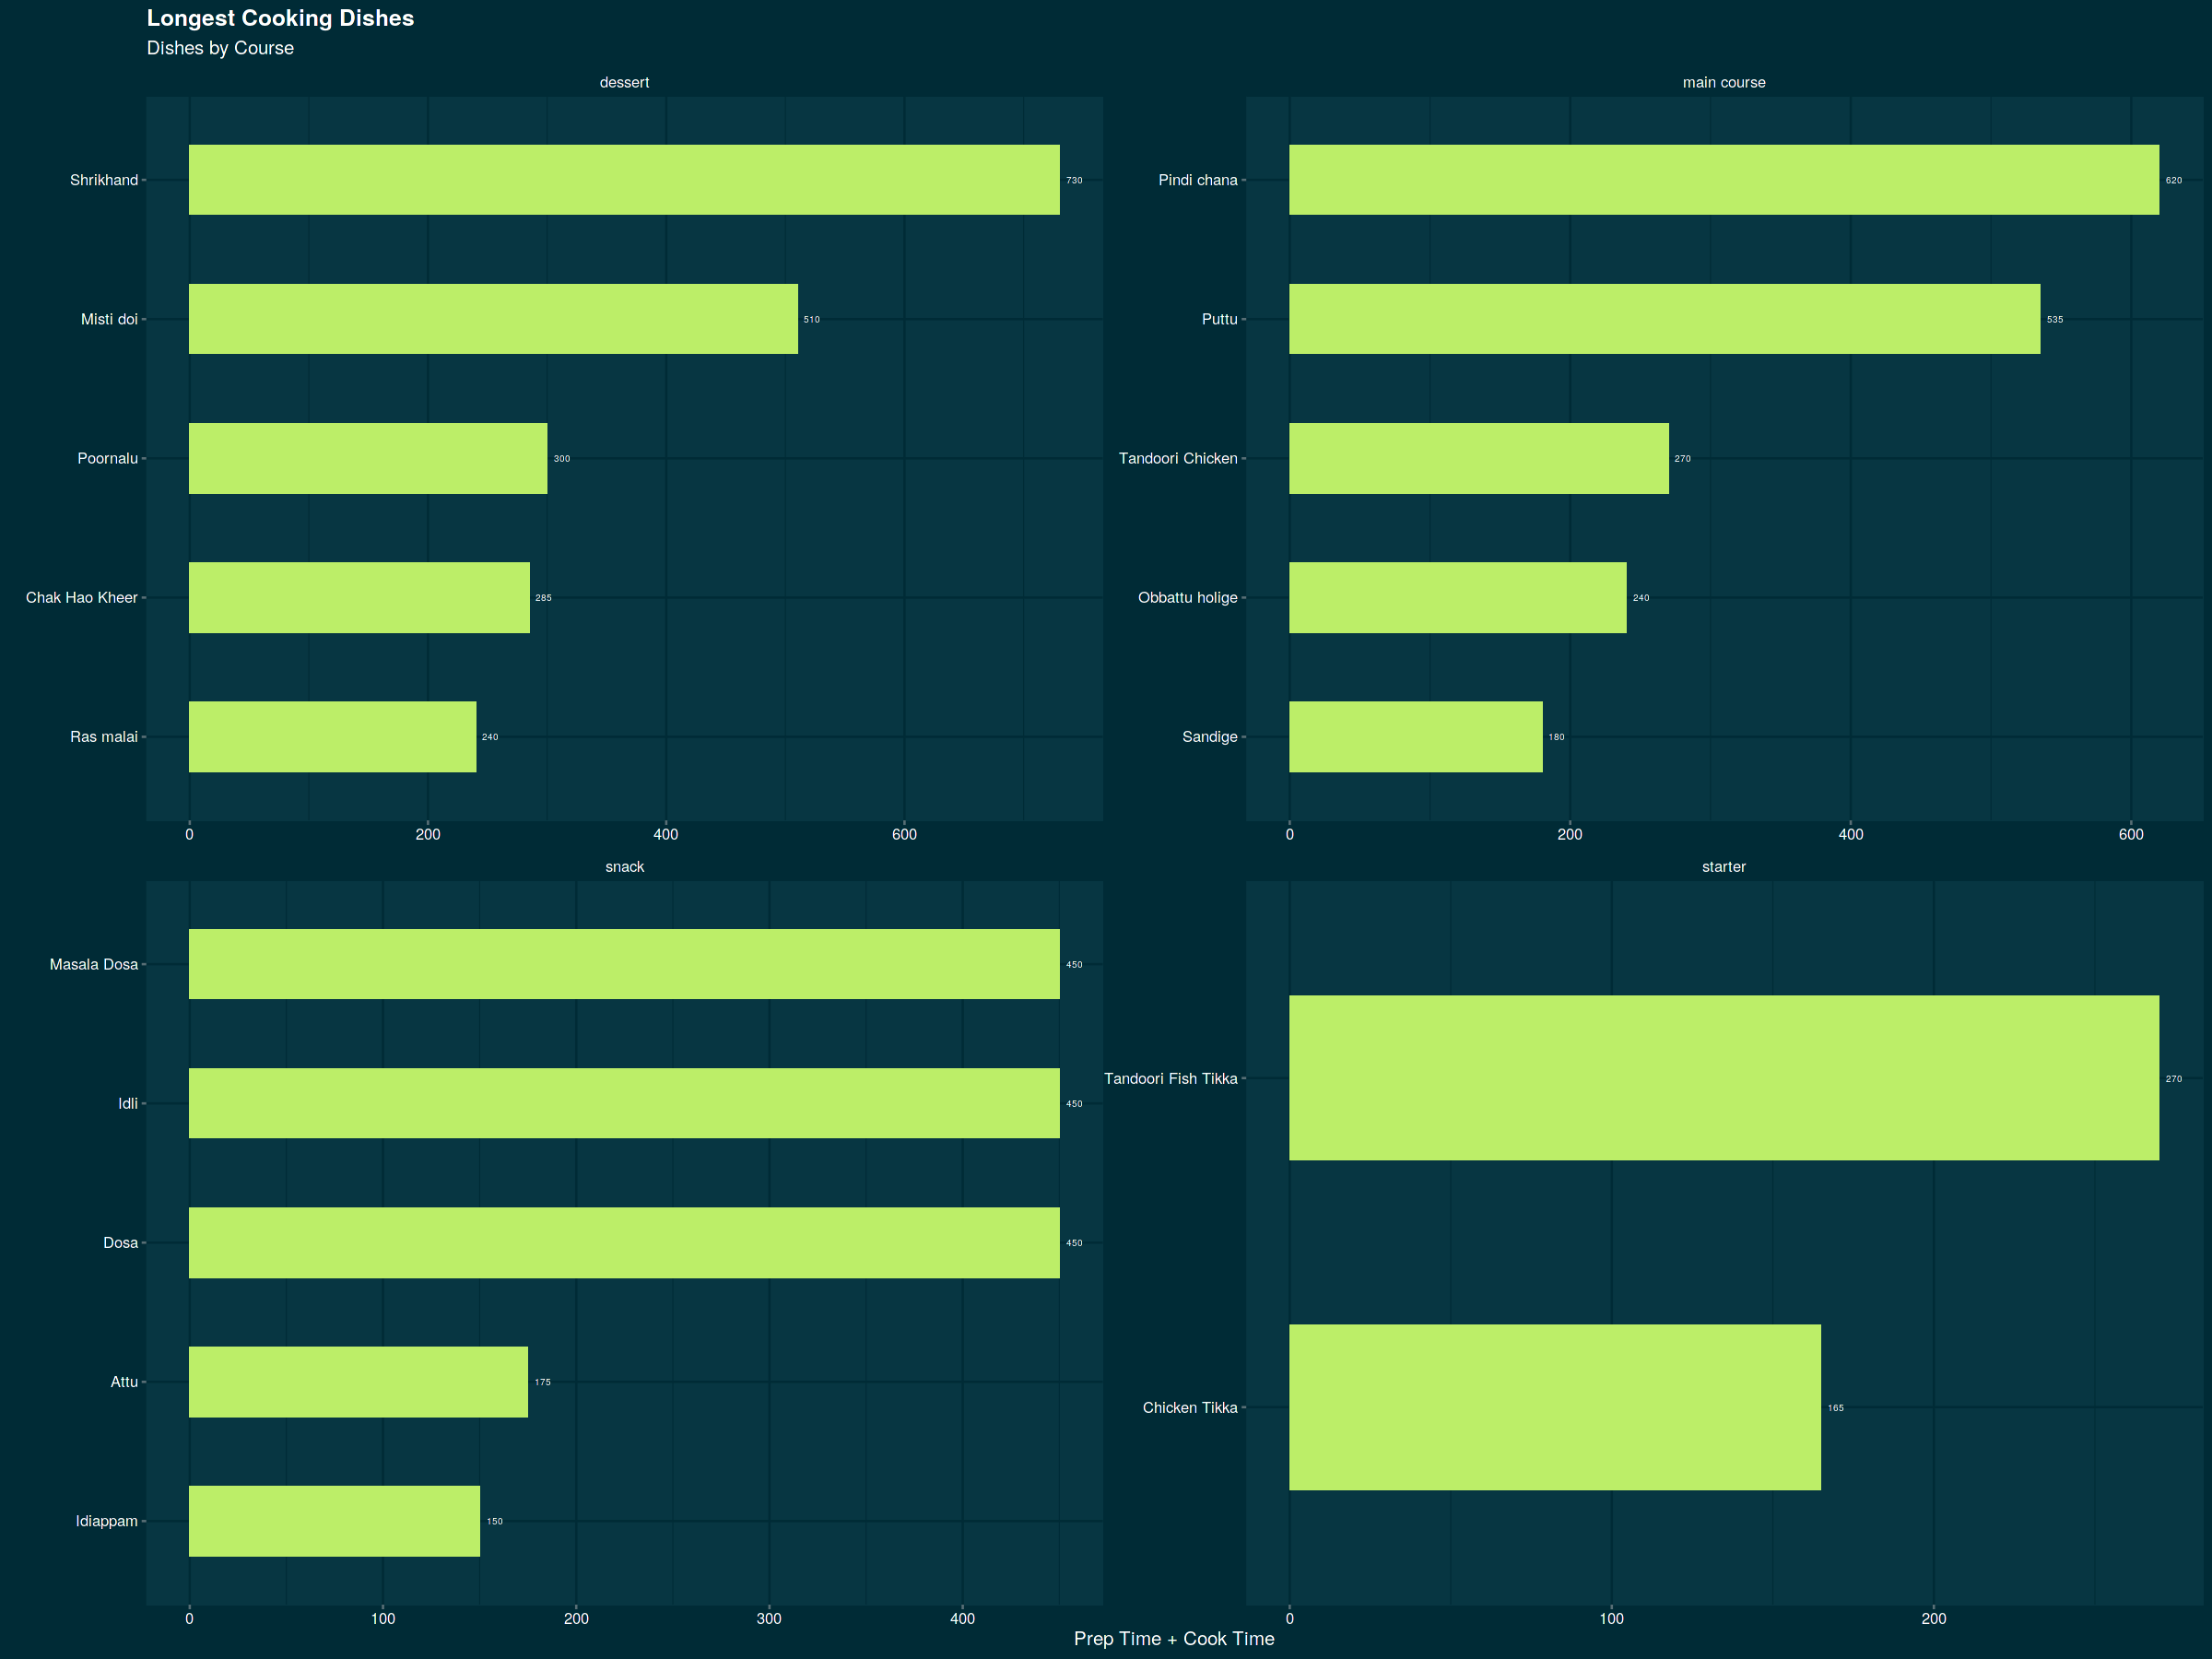

In [21]:
p_longest_dishes

The quickest cooking Indian Dishes are as shown in the plot below. Plots are facted by the course here as well. Chapati, Lassi, Poppadums, Khichu are quick to cook. Point to note Tikkas always take time to cook.



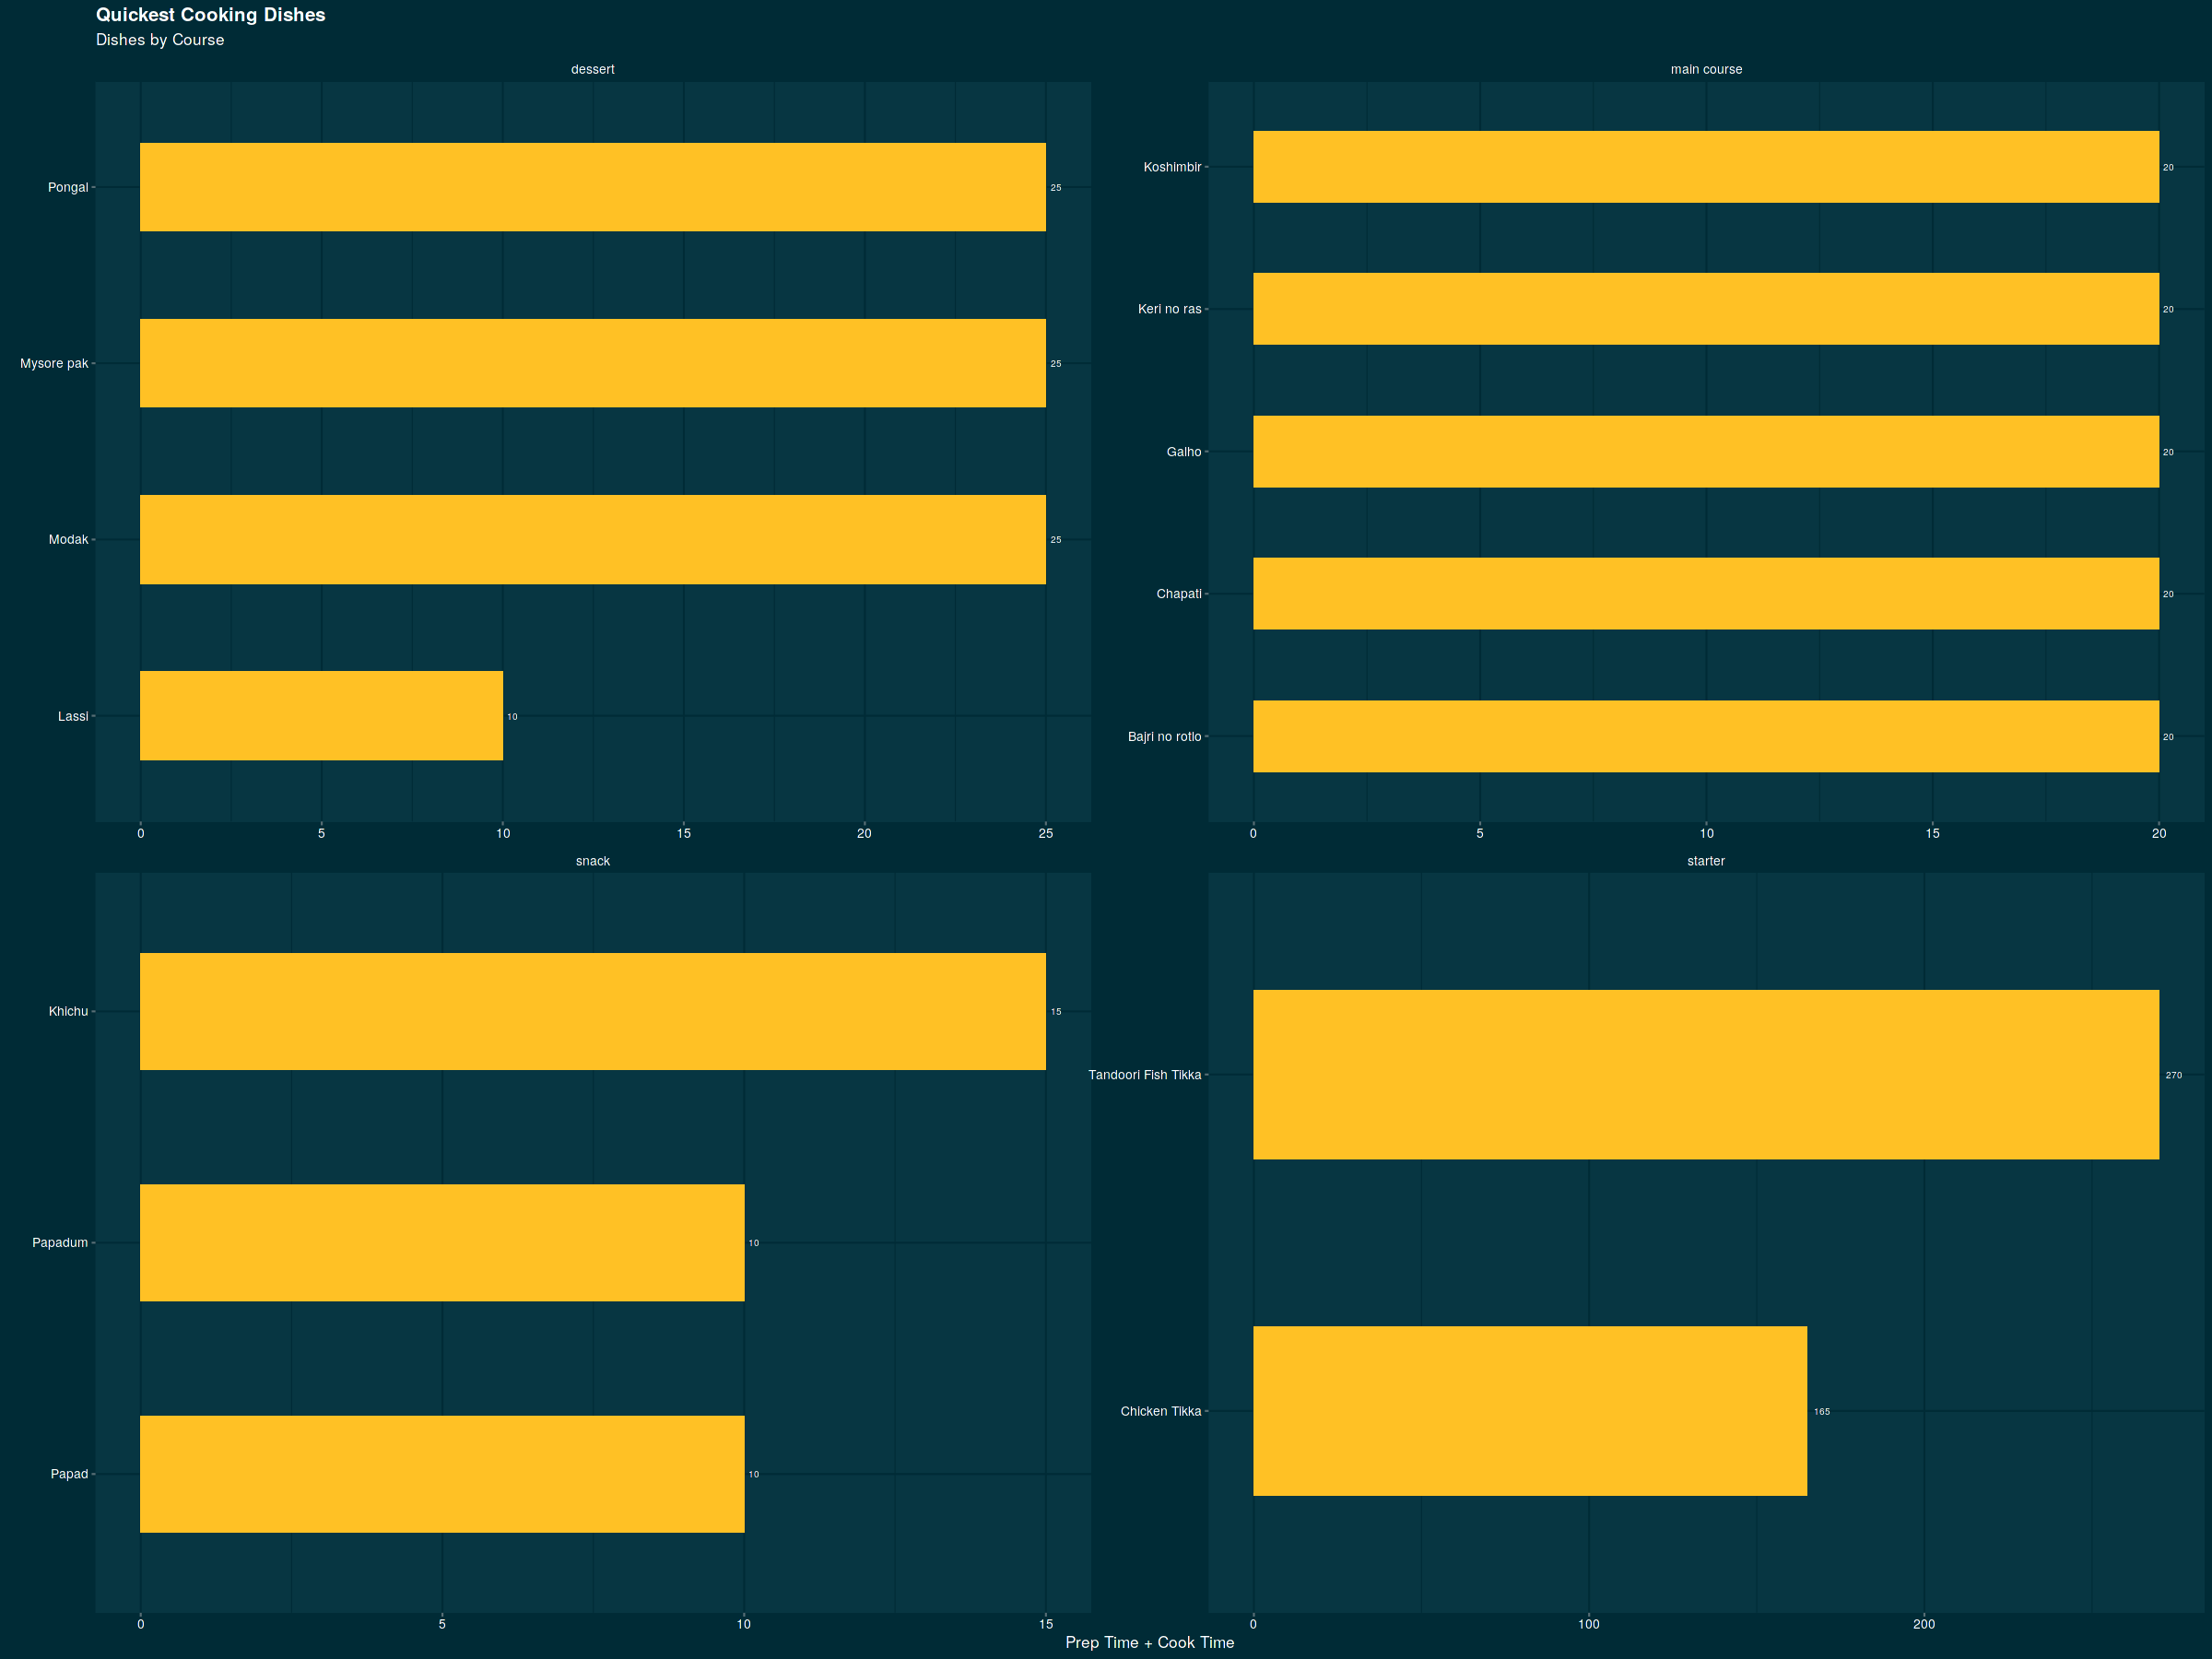

In [22]:
p_quickest_dishes

# 5. Preparation and Cooking Times
In the final section of this notebook we will perform a comparative analysis of the preparation and cooking times of the dishes in this dataset.

In [23]:
my_grob_text <- grobTree(textGrob("High cooking time but low preparation time\nShrikhand takes 720 mins to cook\nand 10 mins to prepare",
                                  x = 0.25, y = 0.9, hjust = 0,
                                  gp = gpar(col = "darkgoldenrod1",
                                            fontsize = 10,
                                            fontface = "bold.italic")))

my_grob_arrows <- grobTree(linesGrob(x = c(0.23, 0.10),
                                     y = c(0.90, 0.95), arrow = arrow(ends = "last", type = "closed", angle = 15),
                                     gp = gpar(col = "darkgoldenrod1", lwd = 0.5, fill = "darkgoldenrod1")))




p_prep_cook_times <- indian_food_details %>% distinct(name, 
                                 flavor_profile, 
                                 cook_time, 
                                 prep_time) %>%
  mutate(flavor_profile = ifelse(flavor_profile == -1, "standard", flavor_profile)) %>% 
  ggplot() + 
  geom_point(mapping = aes(x = prep_time, y = cook_time, color = flavor_profile), 
             position = "jitter", 
             show.legend = TRUE) + 
  scale_color_viridis_d(option = "viridis") + 
  theme_solarized(light = FALSE, base_size = 12) + 
  theme(
    axis.text.x = element_text(colour = "white"), 
    axis.title = element_text(colour = "white"), 
    axis.text.y = element_text(colour = "white"), 
    plot.title = element_text(colour = "gold", face = "bold"), 
    plot.subtitle = element_text(colour = "white"), 
    legend.title = element_text(colour = "white"), 
    legend.text = element_text(colour = "white")
  ) + 
  labs(x = "Preparation Time", 
       y = "Cooking Time", 
       title = "Cooking & Preparation Times")  + 
  annotation_custom(grob = my_grob_text) + 
  annotation_custom(grob = my_grob_arrows)

In [24]:
ggsave(filename = "p_prep_cook_times.png", plot = p_prep_cook_times)

Saving 12.5 x 6.67 in image



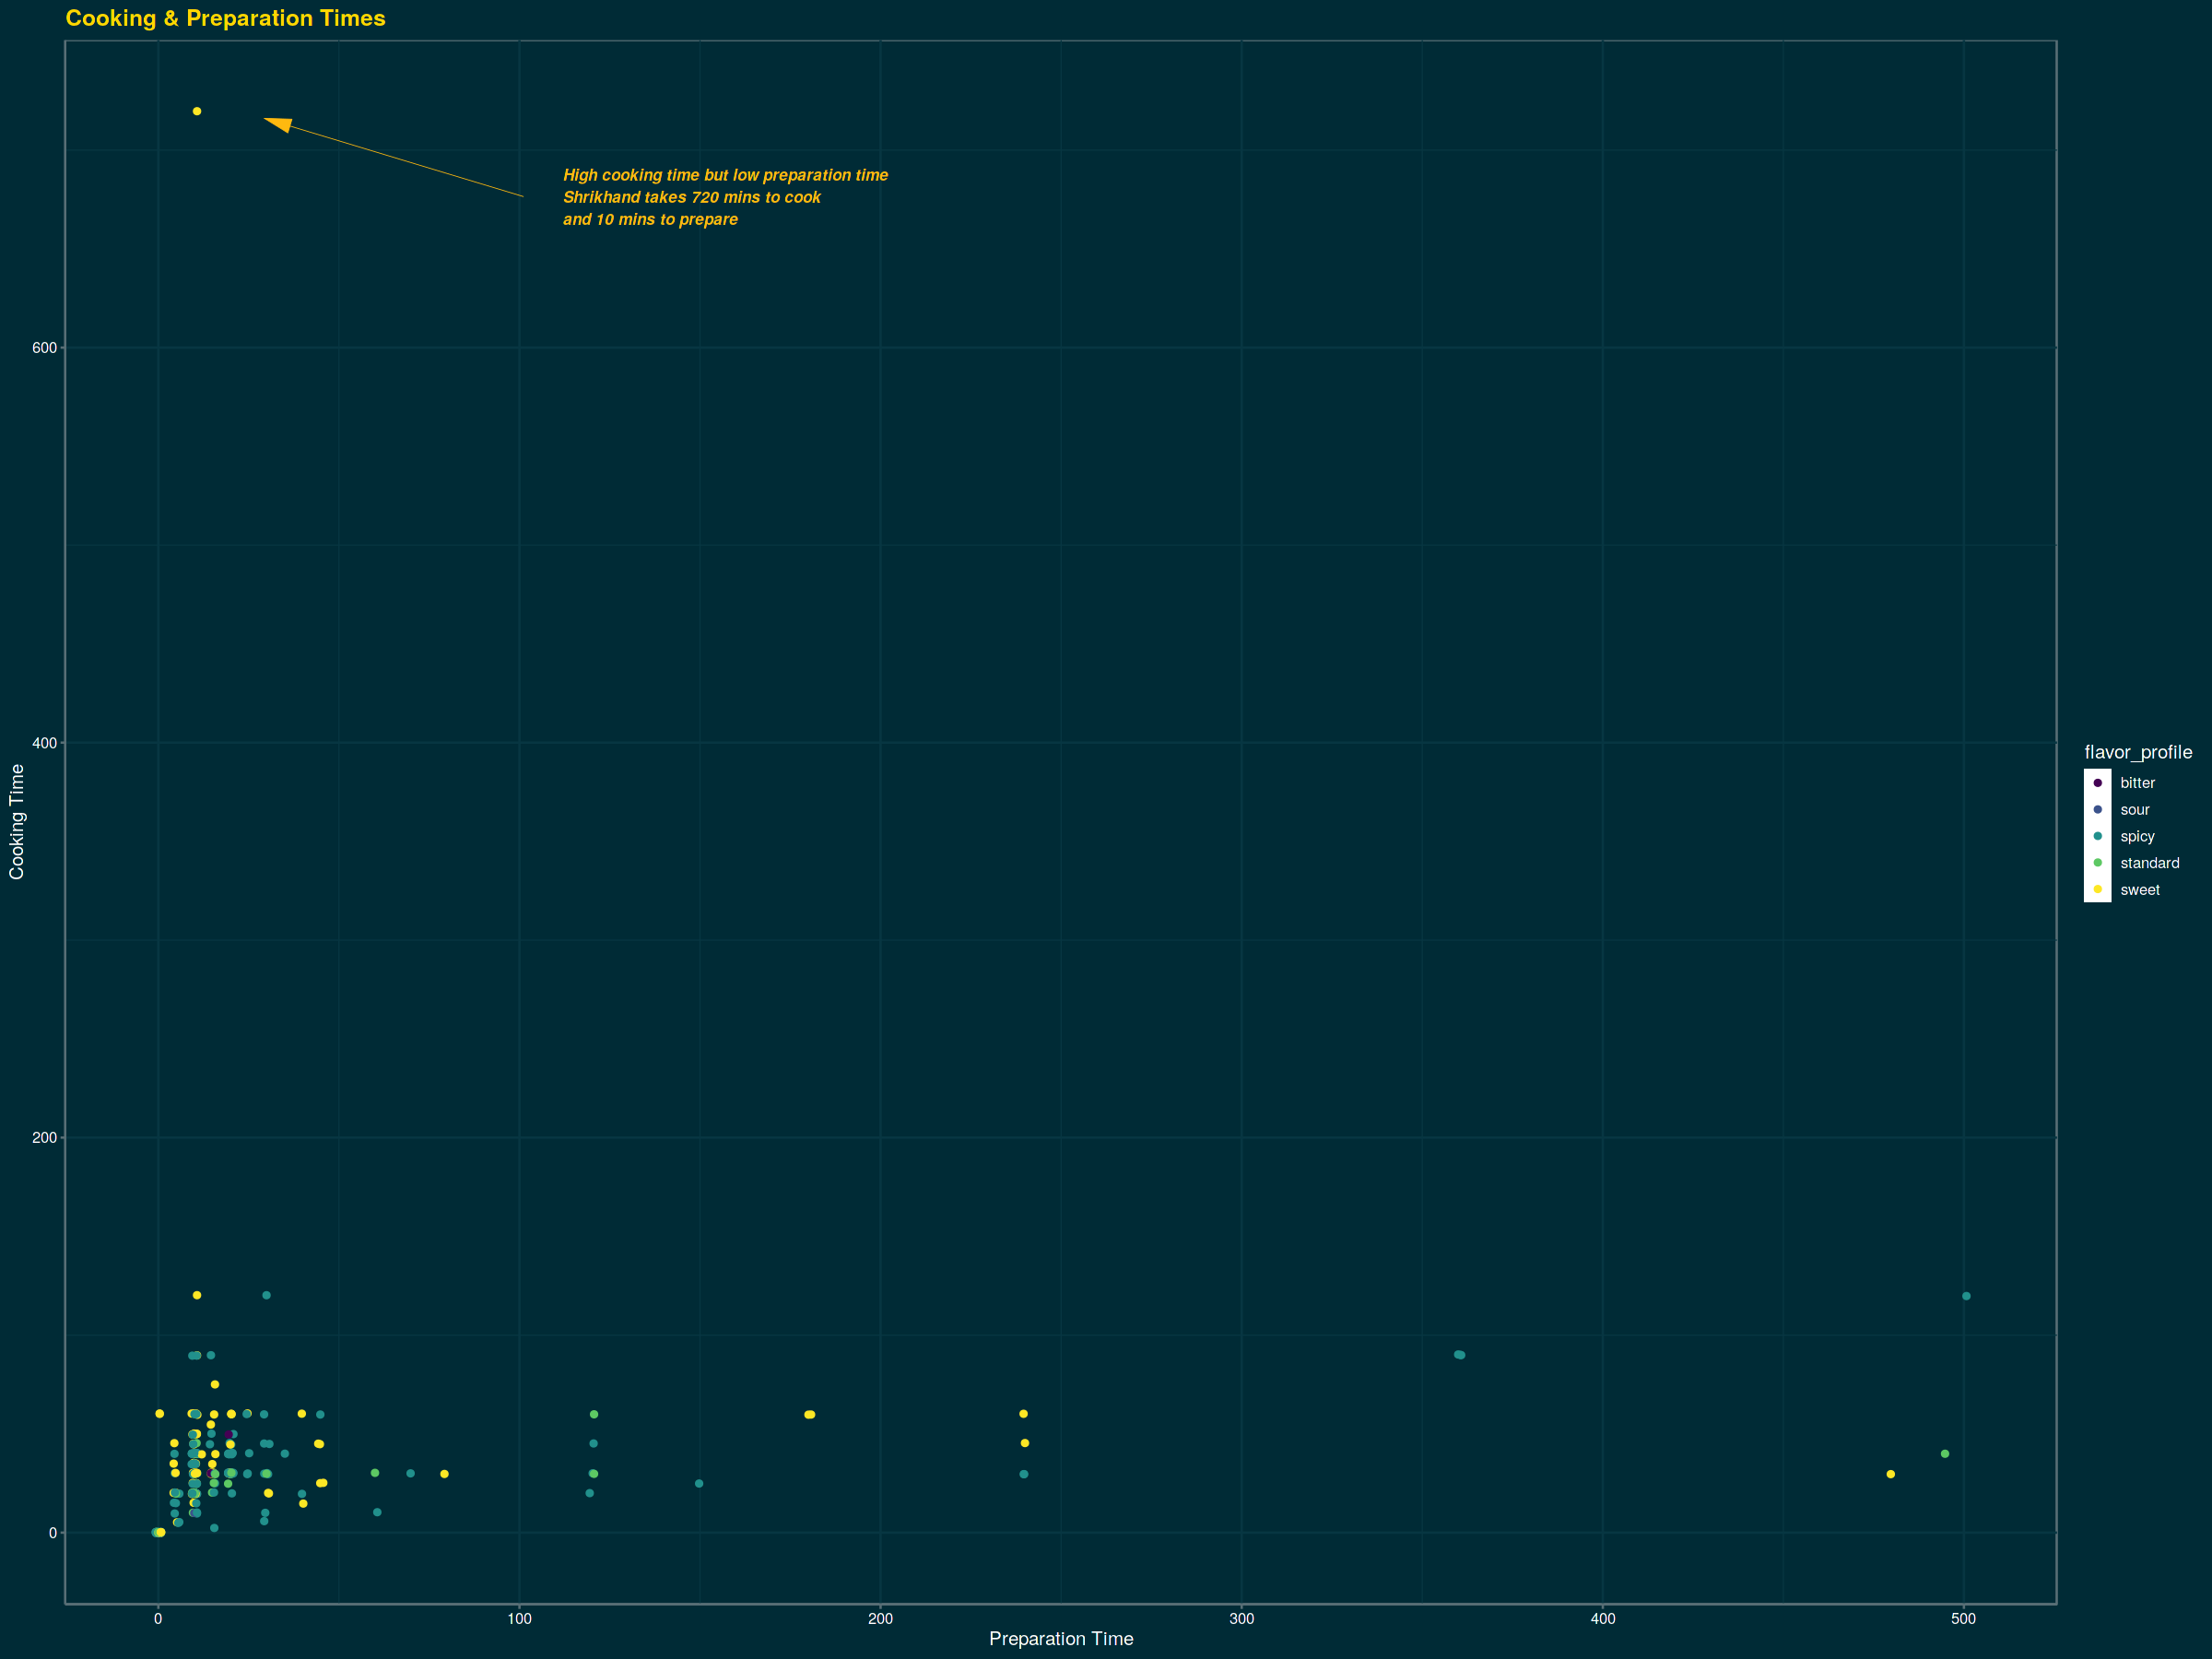

In [25]:
p_prep_cook_times

As we can see from the above graphic.

Most of dishes take an equivalent time to prepare and cook and they lie on lower quadrant of the figure on the bottom left corner.
There is only one sweet dish "Shrikhand" that takes 700 mins to cook but less than 15 mins to prepare. The highlighted text shows that explicitly in the graphic.
There is a set of dishes that takes more time to prepare and comparatively way lesser time to cook. This is something we expect and the points lying horizontally in the lower half of the graphic shows that.



# 6. Regions, State and their Flavor Distributions
As an additional aspect of study, the notebook is enhanced with one more graphic depicting the number of dishes by Indian State and Flavor Profile which is faceted by the Region of the country. This would also be an interesting visualization to understand the taste preferences of different parts of the country

In [26]:
p_region_flavor_distribution <- indian_food %>% filter(region != "None" & state != "None") %>% group_by(region, state, flavor_profile) %>% 
  summarise(cnt = n()) %>%
  ungroup() %>% 
  mutate(state = case_when(state == "Madhya Pradesh" ~ "M. P.", 
                           state == "Jammu & Kashmir" ~ "J & K",
                           state == "West Bengal" ~ "Bengal",
                           state == "Andhra Pradesh" ~ "A. P.",
                           state == "Uttar Pradesh" ~ "U. P.",
                           state == "NCT of Delhi" ~ "Delhi",
                           state == "Chhattisgarh" ~ "Chat'garh",
                           state == "Uttarakhand" ~ "Utt'khand",
                           state == "Maharashtra" ~ "Maha'htra",
                           TRUE ~ state)) %>% 
  ggplot() + 
  geom_point(mapping = aes(x = flavor_profile, y = state), show.legend = FALSE, size = 8, color = "chartreuse4") + 
  geom_text(mapping = aes(x = flavor_profile, y = state, label = cnt), show.legend = FALSE, size = 4, color = "white", fontface = "bold") + 
  scale_x_discrete(guide = guide_axis(n.dodge = 2)) + 
  facet_wrap(facets = ~region, nrow = 2, scales = "free")  + 
  theme_solarized_2(light = FALSE, base_size = 12) + 
  theme(axis.text.x = element_text(colour = "white"), 
        axis.title = element_text(colour = "white"), 
        axis.text.y = element_text(colour = "white"), 
        plot.title = element_text(colour = "gold", face = "bold"), 
        plot.subtitle = element_text(colour = "white"), 
        strip.text = element_text(colour = "goldenrod1", face = "bold")) + 
  labs(x = "", 
       y = "", 
       title = "Indian Cuisine - Regional Preferences", 
       subtitle = "Region & State wise number of dishes with their flavor profile")

ggsave(filename = "p_region_flavor_distribution.png", plot = p_region_flavor_distribution)


`summarise()` regrouping output by 'region', 'state' (override with `.groups` argument)

Saving 12.5 x 6.67 in image



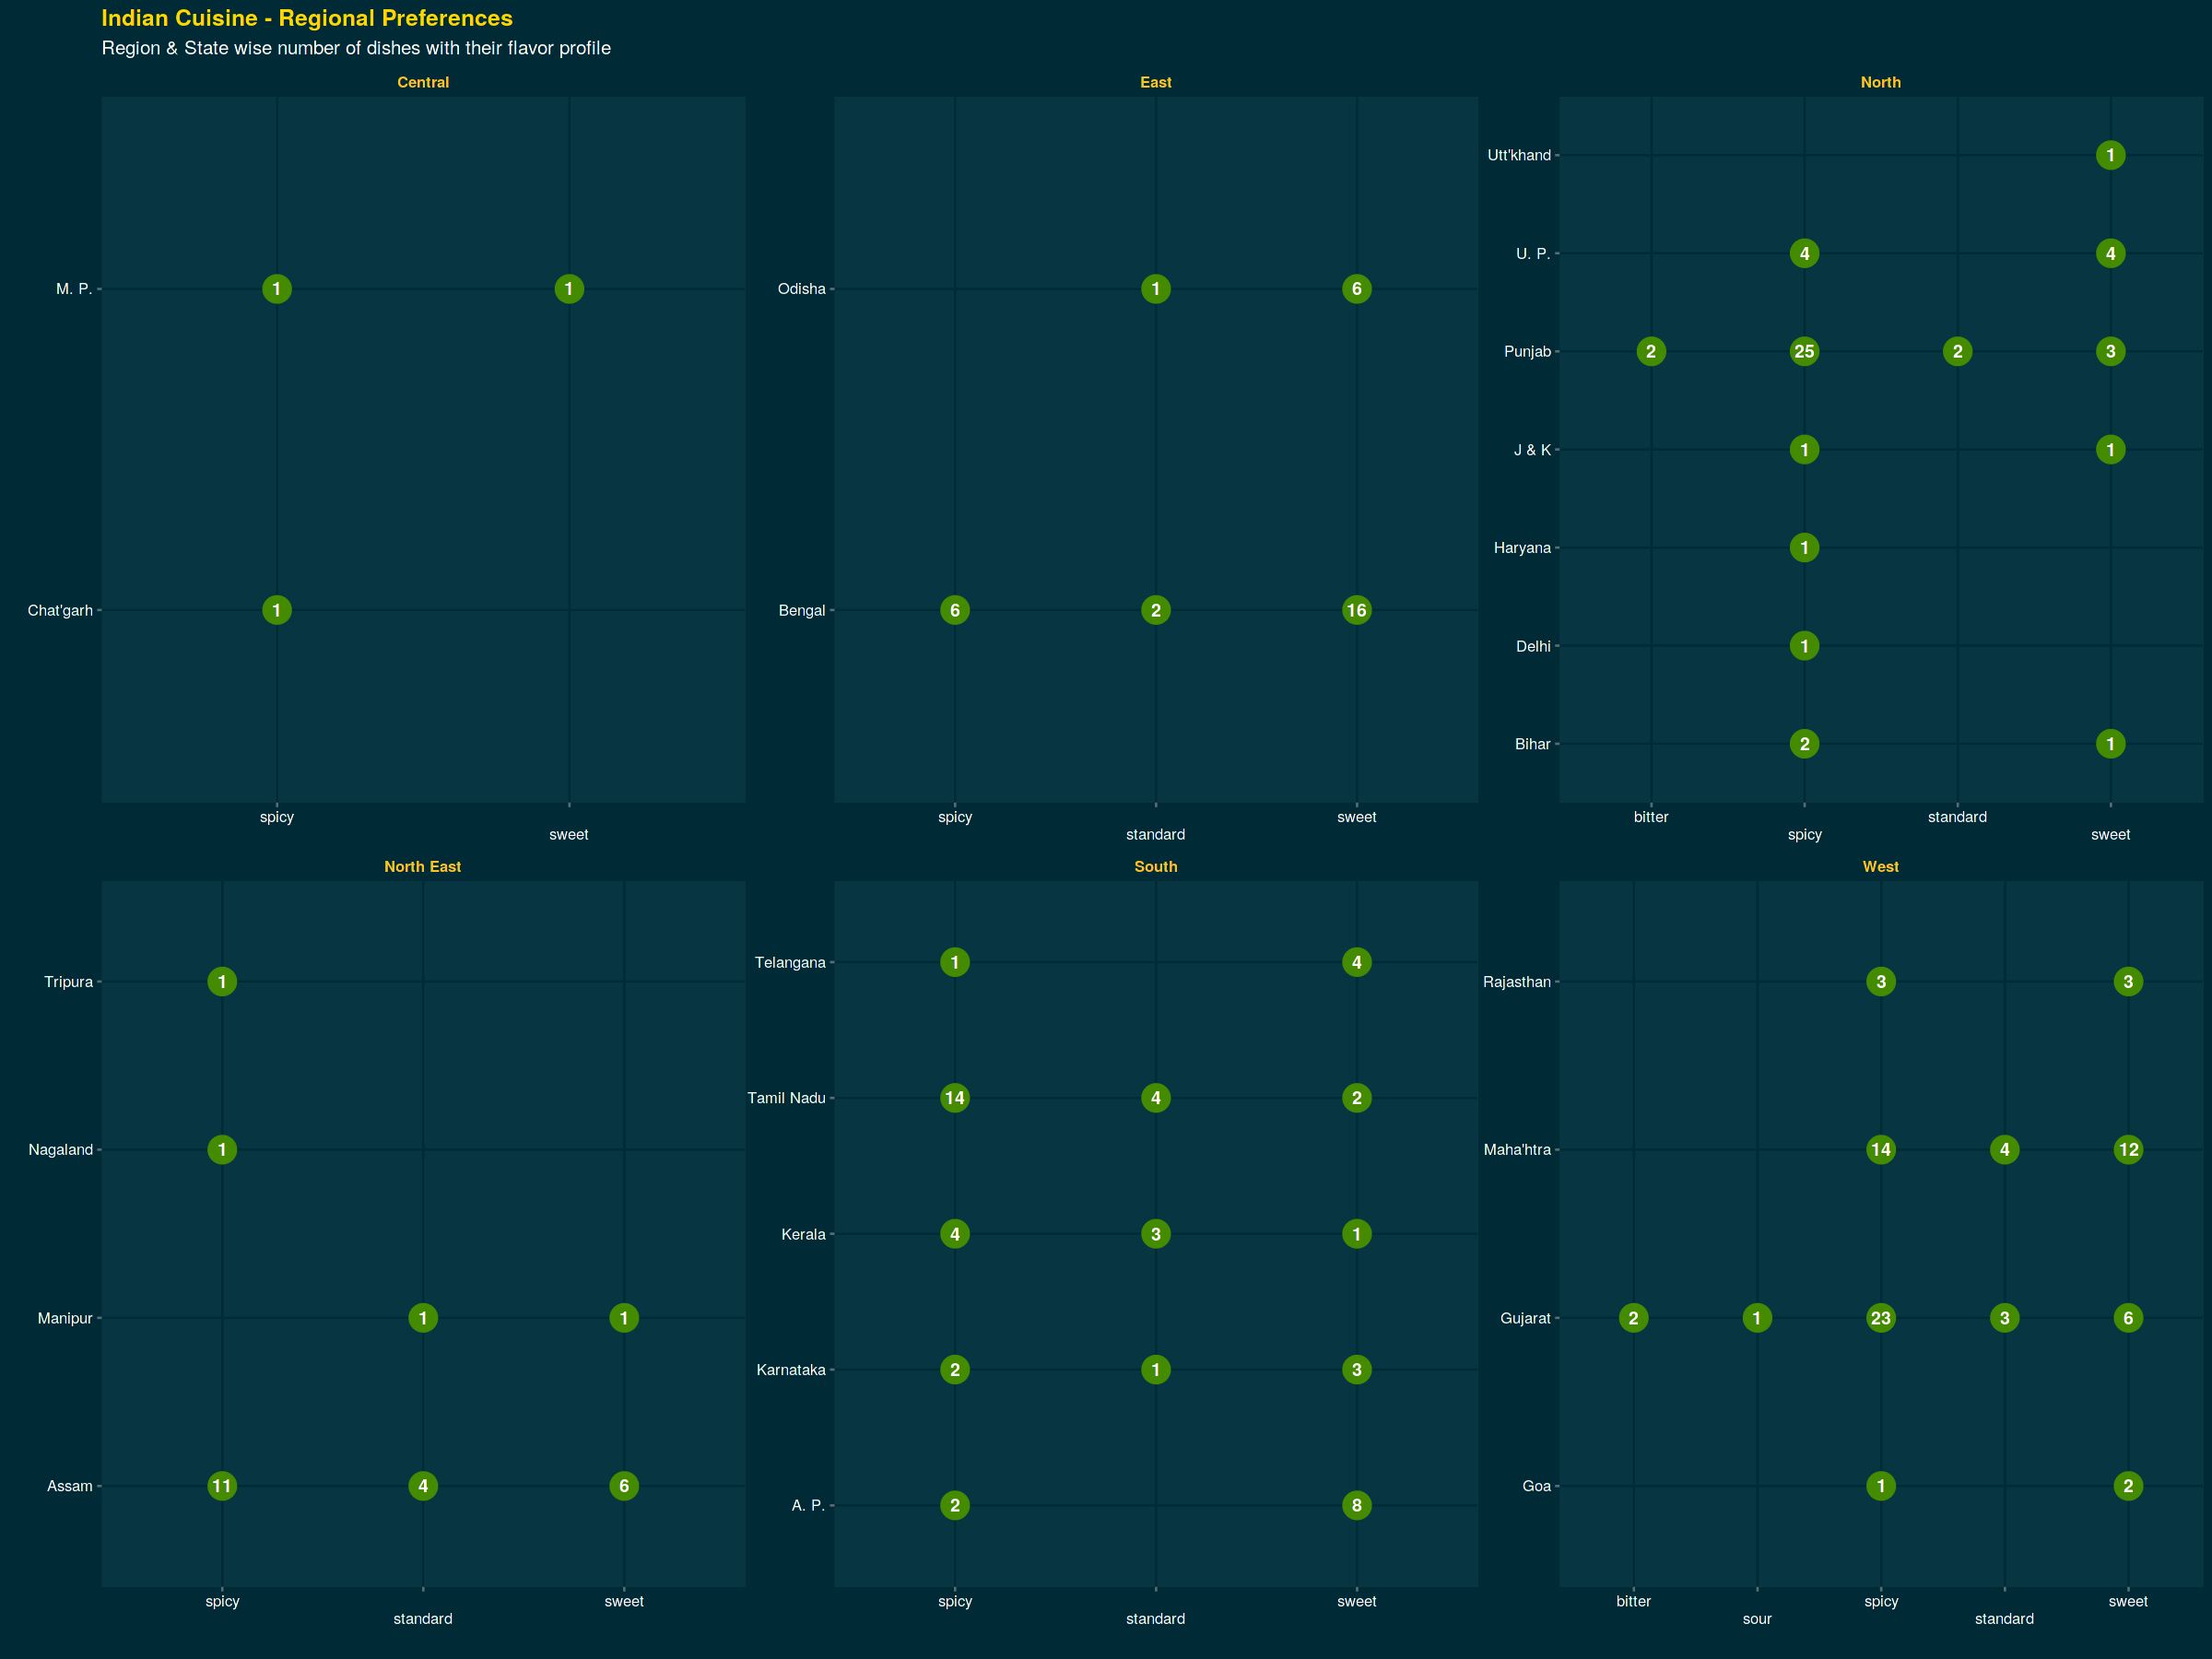

In [27]:
p_region_flavor_distribution

It is important to note that while creating the above graphic a set of around 29 dishes were found to not have a flavor profile in the dataset such as Chapati, Nan, Rongi, Kanji etc. These dishes were been marked as having standard flavor profiles before proceeding with creating the graphic.

The following observations are noteworthy from the above graphic :-

Bengal from the Eastern part of the country loves having sweet dishes (16 sweet dishes). 
Punjab from the Northen part of the country loves spicy food more than anything else. Punjabi food is the most common and popular food from the North India. Punjab has the most numbered circles in that "North" facet of the graphic
Similarly Assamese food is the most common and popular among the North Eastern States. Assamese food is also mostly spicy with 11 of them as spicy followed by sweet and standard flavors.
South India also has a greater proportion of foods as spicy with Tamil Nadu having quite a large number of dishes which are spicy.
The West also has good distribution of spicy and sweet dishes with Maharashtra 14 spicy and 12 sweet dishes. Gujarat as an exception has 2 bitter flavored dishes and 1 sour flavored dish.


# Conclusion
The Indian Cuisine is as varied it can be where due to the various food culture of different parts of the country as well as the fact that India is home to quite a few religions and castes there are a plethora of India dishes. Quite a good number of ingredients are used in these dishes depending upon the food tastes of the local people and their culture. Also Indian dishes take a good amount of time to cook and prepare and there are a few instances where foods similar in taste and ingredients are called by different names. This is another facet of the Indian Cuisine.

